# Food Deserts in Davidson County

### In this workshop we will cover:
- Using `pandas` for data analysis
- Geospatial data
- Accessing data through webscraping
- Combining and Analyzing data
...keep adding to the list

# What is a food desert?

## From the USDA website:  

#### The area of a food desert is definied by the census tract

https://www.ers.usda.gov/data-products/food-access-research-atlas/documentation/
"Most measures and definitions take into account at least some of the following indicators of access:

- Accessibility to sources of healthy food, as measured by distance to a store or by the number of stores in an area.
- Individual-level resources that may affect accessibility, such as family income or vehicle availability.
- Neighborhood-level indicators of resources, such as the average income of the neighborhood and the availability of public transportation."  

"This program defines a low-income census tract as any tract where:

- The tract’s poverty rate is 20 percent or greater; or
- The tract’s median family income is less than or equal to 80 percent of the State-wide median family income; or
- The tract is in a metropolitan area and has a median family income less than or equal to 80 percent of the metropolitan area's median family income."  

"Three measures of food access based on distance to a supermarket are provided in the Atlas:

- Low-income census tracts where a significant number (at least 500 people) or share (at least 33 percent) of the population is greater than ½ mile from the nearest supermarket, supercenter, or large grocery store for an urban area or greater than 10 miles for a rural area. Using this measure, an estimated 54.4 million people, or 17.7 percent of the U.S. population, live in tracts that are low-income and low access and are more than ½ mile or 10 miles from the nearest supermarket.
- Low-income census tracts where a significant number (at least 500 people) or share (at least 33 percent) of the population is greater than 1.0 mile from the nearest supermarket, supercenter, or large grocery store for an urban area or greater than 10 miles for a rural area. This measure shows that an estimated 19 million people, or 6.2 percent of the U.S. population, live in low-income and low access tracts and are more than 1 mile or 10 miles from a supermarket.
- Low-income census tracts where a significant number (at least 500 people) or share (at least 33 percent) of the population is greater than 1.0 mile from the nearest supermarket, supercenter, or large grocery store for an urban area or greater than 20 miles for a rural area. Under this measure, an estimated 17.3 million people, or 5.6 percent of the U.S. population, live in low-income and low access tracts and are more than 1 mile or 20 miles from a supermarket."

#### Based on this we need to know 2 things:
1. If a census tract is a `low income` census tract
2. Number and location of Supermarkets/source of fresh food

#### Breaking these criteria down a little further:
1. Census tract boundaries
2. Income information
3. Location of farmers markets, supermarkets, supercenters, large markets
4. Transportation access (optional)
5. Impact of stores that don't provide fresh food have on food deserts (stretch)

#### We can then combine these data to find the proportion of low-income census tracts that are too far away from Supermarkets/sources of fresh produce, resulting in a food desert

In [1]:
## Let's start by importing the packages we are going to use:
import pandas as pd # main data analysis package
import numpy as np # used for a number of mathematical calculations
import matplotlib.pyplot as plt # used for making plots
import geopandas as gpd # used for working with geographic data
import json # used for interacting with JSON file types
import math # used for multiple formulas and unit conversions
from sklearn.metrics.pairwise import haversine_distances
import ast
import requests
from bs4 import BeautifulSoup as BS
from shapely.ops import unary_union

%matplotlib inline

Now we can import information about census tracts in Tennessee. The file we will be using is a shape file (`.shp`), which means there is geometry information as part file. We will see what this means in more detail a little later, but for now it means we will need to import the file with `geopandas` to preserve the geometry data. 

In [2]:
tennessee_tracts = gpd.read_file('data/cb_2018_47_tract_500k/cb_2018_47_tract_500k.shp')

Now we have read in the data and saved it to a variable called `tennessee_tracts`. This variable is a `GeoDataFrame` (gdf). The first thing to do with any data set is to explore it to get a better understanding of the data inside. We can start by looking at the first few rows using the `.head()` method.

In [3]:
tennessee_tracts.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,47,093,001900,1400000US47093001900,47093001900,19,CT,2203514,13116,"POLYGON ((-83.90062 35.99202, -83.88800 36.000..."
1,47,093,003902,1400000US47093003902,47093003902,39.02,CT,3451146,0,"POLYGON ((-83.98563 36.00119, -83.98152 36.004..."
2,47,093,004404,1400000US47093004404,47093004404,44.04,CT,5964584,11451,"POLYGON ((-84.03695 35.93007, -84.02293 35.933..."
3,47,093,005708,1400000US47093005708,47093005708,57.08,CT,3557676,38601,"POLYGON ((-84.11800 35.86332, -84.11387 35.866..."
4,47,093,006103,1400000US47093006103,47093006103,61.03,CT,6437142,0,"POLYGON ((-84.07012 36.02888, -84.06820 36.031..."


Most of the columns are identifiers of some kind. The important column is the `geometry` column, which contains the information about the census tract boundaries. We can look more closely at the geometry of one census tract by _**slicing**_ the gdf to just the data we are interested in. We can do that using the `.loc[<row_index>, <column_index>]` method.

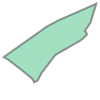

In [4]:
# With .loc you can specify the rows and columns you want inside brackets:

tennessee_tracts.loc[0, 'geometry']

Since python is index base 0, to get the first row of the GDF we put `0` in the first position in the brackets. Additionally, since we wanted the "geometry" column, we put `'geometry'` in the second position in the brackets.

But this maybe wasn't what we expected, since we got a shape instead of thing starting with `Polygon` like we expected. This is because `Polygon` is a specific object type that stores information about a shape, so when jupyter notebook sees a `Polygon` object, we get back a shape.

We can dig in a little deeper to better understand this:

In [5]:
# Save the first row POLYGON to a variable
single_tract = tennessee_tracts.loc[0, 'geometry']

# print the type of the object
print('object type: ',type(single_tract), '\n')

# print what is stored inside the object
print('object contents: ', single_tract)

object type:  <class 'shapely.geometry.polygon.Polygon'> 

object contents:  POLYGON ((-83.900621 35.992018, -83.88800499999999 36.000938, -83.88472 36.002678, -83.873758 36.007501, -83.87545 36.00199, -83.877071 35.99957, -83.87666899999999 35.999198, -83.87647899999999 35.9985, -83.87813 35.996968, -83.885621 35.99264, -83.889646 35.987395, -83.890748 35.985249, -83.891792 35.98468, -83.89220399999999 35.985574, -83.89385 35.987008, -83.89928599999999 35.991254, -83.900621 35.992018))


From this we can see that the object type is indeed a `Polygon`, and when we `print` the contents we can see the full data stored in the object: coordinate pairs that indicate the boundaries of the tract.

Geopandas can accomodate many different coordinate reference systems (CRS), each slightly different from each other. In order to ensure we are using the correct CRS, we can explicitally set it using the `.crs` attribute:

In [6]:
tennessee_tracts.crs = "EPSG:4326"

"EPSG:4326" is one of the more common CRS and is the one that was used for generating the census tract boundaries.

Now that we have set the CRS, we can see all the census tracts together by applying the `.plot()` method to the `tennessee_tracts` GDF:

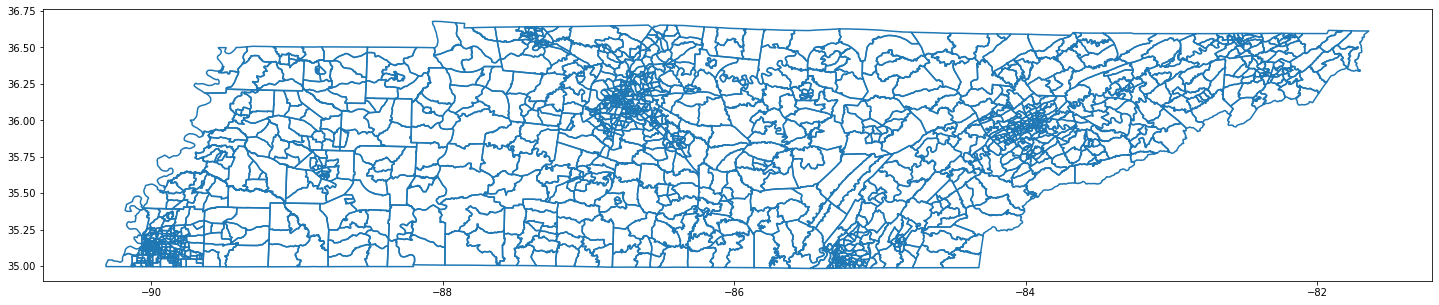

In [7]:
tennessee_tracts.boundary.plot(figsize = (25, 5))

Here we only are showing the boundaries for each census tract in Tennessee. The plot size is increased so we can see more of the fine details.

We are only interested in Davidson County for this analysis, so we can subset the gdf to only include data from Davidson County by using some of the other columns.

In [8]:
# Select only Davidson County tracts (COUNTYFP == 037)
davidson_tracts = tennessee_tracts[tennessee_tracts['COUNTYFP']=='037'].reset_index(drop = True)

What the above code is saying is take only rows from the `tennessee_tracts` gdf where the value in the `'COUNTYFP'` column is equal to `'037'`. Since we are only taking some of the rows from the middle, the labels for the rows will be off. `.reset_index(drop = True)` will remove the old labels and add back new ones that start at `0`

Let's take a look at what we're left with:

In [9]:
davidson_tracts.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,47,037,015625,1400000US47037015625,47037015625,156.25,CT,9544531,1931522,"POLYGON ((-86.65754 36.11937, -86.65558 36.122..."
1,47,037,016000,1400000US47037016000,47037016000,160,CT,1158914,0,"POLYGON ((-86.77265 36.14987, -86.76948 36.151..."
2,47,037,017300,1400000US47037017300,47037017300,173,CT,2362363,0,"POLYGON ((-86.75091 36.12039, -86.75051 36.121..."
3,47,037,018409,1400000US47037018409,47037018409,184.09,CT,3432622,0,"POLYGON ((-86.98225 36.07529, -86.98171 36.075..."
4,47,037,019106,1400000US47037019106,47037019106,191.06,CT,1853544,0,"POLYGON ((-86.74414 36.04342, -86.74375 36.047..."


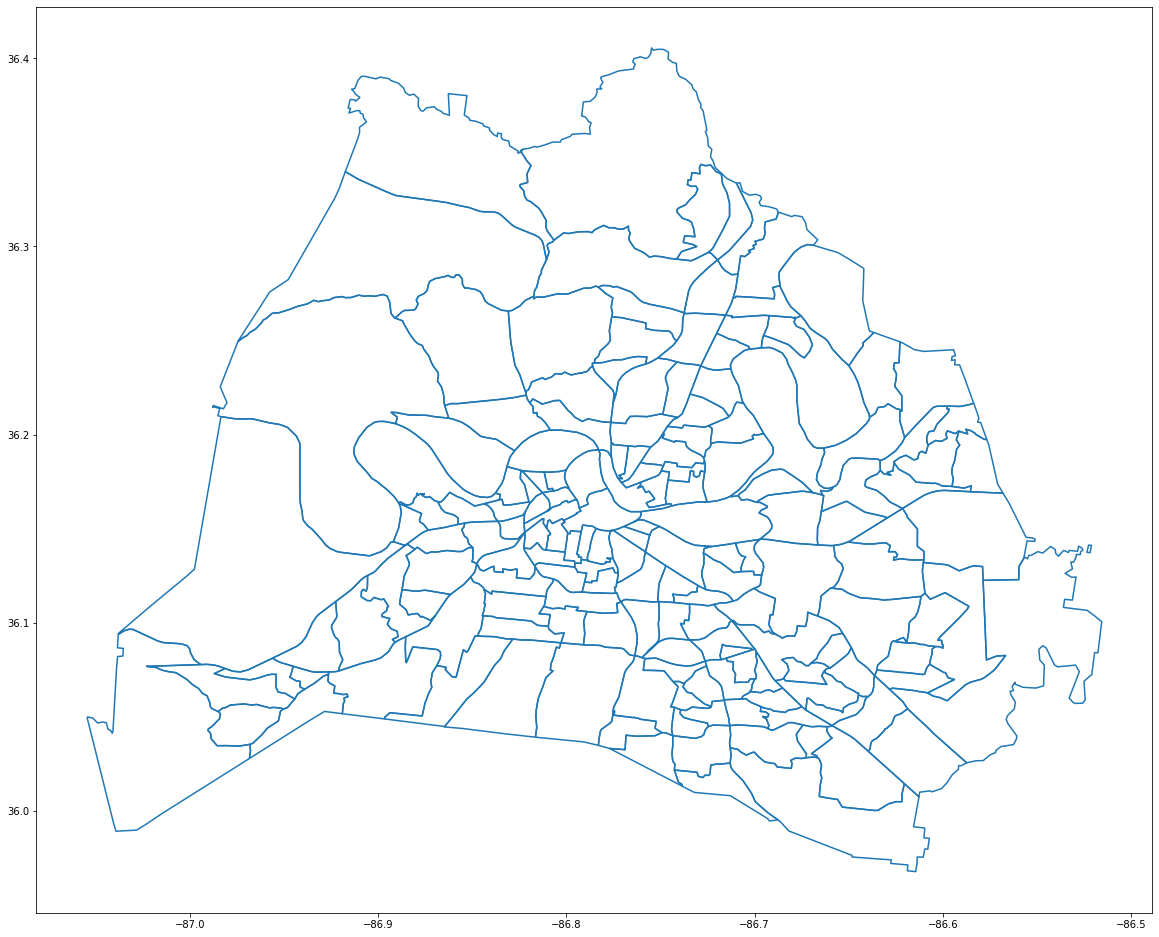

In [10]:
davidson_tracts.boundary.plot(figsize = (20, 20))

Let's get the outline of Davidson county as well

In [11]:
davidson_county = gpd.read_file('data/Davidson County Border (GIS).geojson')
davidson_county.crs = "EPSG:4326"

## Now that we have the census tract boundaries, we can look at poverty rates across them. For that we will import poverty rate data

In [12]:
# from https://censusreporter.org/data/table/?table=B17001&geo_ids=14000US47037016000,05000US47037,04000US47,01000US,140|05000US47037&primary_geo_id=14000US47037016000
poverty_rates_davidson = pd.read_csv('data/acs2018_5yr_B17001_14000US47037011800/acs2018_5yr_B17001_14000US47037011800.csv')
poverty_rates_davidson.head()

,geoid,name,B17001001,"B17001001, Error",B17001002,"B17001002, Error",B17001003,"B17001003, Error",B17001004,"B17001004, Error",...,B17001055,"B17001055, Error",B17001056,"B17001056, Error",B17001057,"B17001057, Error",B17001058,"B17001058, Error",B17001059,"B17001059, Error"
0,01000US,United States,314943184,10644,44257979,285269,19737150,135323,2133564,23874,...,17570934,23751,19123455,21888,18897286,18735,13610378,7857,10144490,8532
1,04000US47,Tennessee,6488786,1266,1046508,14988,464678,8580,55205,1758,...,356279,1753,392773,1961,391322,1709,298198,1166,203400,1187
2,05000US47037,"Davidson County, TN",663232,1047,108515,3450,49607,1995,5931,590,...,39021,590,36479,423,36795,550,23796,322,17236,346
3,14000US47037010103,"Census Tract 101.03, Davidson, TN",2515,223,143,63,41,30,0,12,...,118,47,176,54,208,57,158,55,95,34
4,14000US47037010104,"Census Tract 101.04, Davidson, TN",2934,228,248,159,111,76,19,32,...,160,74,241,77,287,81,152,48,87,45


Looking at the `head` we can see that the first 3 rows seem to be aggregate data for the US, Tennessee, and Davidson County. Since we're only interested in the tract level data, we can remove those first 3 rows using the `.drop()` method:

In [13]:
# remove aggregation rows
poverty_rates_davidson_tract = poverty_rates_davidson.drop([0, 1, 2])
poverty_rates_davidson_tract.head()

,geoid,name,B17001001,"B17001001, Error",B17001002,"B17001002, Error",B17001003,"B17001003, Error",B17001004,"B17001004, Error",...,B17001055,"B17001055, Error",B17001056,"B17001056, Error",B17001057,"B17001057, Error",B17001058,"B17001058, Error",B17001059,"B17001059, Error"
3,14000US47037010103,"Census Tract 101.03, Davidson, TN",2515,223,143,63,41,30,0,12,...,118,47,176,54,208,57,158,55,95,34
4,14000US47037010104,"Census Tract 101.04, Davidson, TN",2934,228,248,159,111,76,19,32,...,160,74,241,77,287,81,152,48,87,45
5,14000US47037010105,"Census Tract 101.05, Davidson, TN",4132,385,438,143,183,74,24,18,...,193,93,429,139,365,97,385,80,181,59
6,14000US47037010106,"Census Tract 101.06, Davidson, TN",3142,249,607,268,256,125,5,8,...,279,75,220,63,188,58,89,51,63,38
7,14000US47037010201,"Census Tract 102.01, Davidson, TN",4677,354,819,343,314,167,34,54,...,207,58,378,99,267,96,163,67,189,68


The column names are a little confusing, but luckily there are more understandable names in another metadata file. It is saved in `JSON` file, so we will use python to safely open, import the data, then close the file.

In [14]:
with open('data/acs2018_5yr_B17001_14000US47037011800/metadata.json') as f:
    column_names = json.load(f)

# Take a look
column_names

{'release': {'id': 'acs2018_5yr',
  'name': 'ACS 2018 5-year',
  'years': '2014-2018'},
 'tables': {'B17001': {'columns': {'B17001001': {'indent': 0,
     'name': 'Total:'},
    'B17001002': {'indent': 1,
     'name': 'Income in the past 12 months below poverty level:'},
    'B17001003': {'indent': 2, 'name': 'Male:'},
    'B17001004': {'indent': 3, 'name': 'Under 5 years'},
    'B17001005': {'indent': 3, 'name': '5 years'},
    'B17001006': {'indent': 3, 'name': '6 to 11 years'},
    'B17001007': {'indent': 3, 'name': '12 to 14 years'},
    'B17001008': {'indent': 3, 'name': '15 years'},
    'B17001009': {'indent': 3, 'name': '16 and 17 years'},
    'B17001010': {'indent': 3, 'name': '18 to 24 years'},
    'B17001011': {'indent': 3, 'name': '25 to 34 years'},
    'B17001012': {'indent': 3, 'name': '35 to 44 years'},
    'B17001013': {'indent': 3, 'name': '45 to 54 years'},
    'B17001014': {'indent': 3, 'name': '55 to 64 years'},
    'B17001015': {'indent': 3, 'name': '65 to 74 years'

This is a pretty complex object. We may need to understand it a little better to use it.

In [15]:
print(type(column_names))
print(column_names.keys())

<class 'dict'>
dict_keys(['release', 'tables'])


`column_names` is a dictionary, which is a collection of `key`:`value` pairs. If we look at the keys we can see `release` and `tables`. There is obviously much more information than that, so the rest must be burried inside the top level keys. We are interested in table data so lets start there. We can access the values associated with a key by using `[]`.

In [16]:
print(column_names['tables'].keys(), '\n')
print(column_names['tables']['B17001'].keys(), '\n')
print(column_names['tables']['B17001']['columns'].keys(), '\n')
print(column_names['tables']['B17001']['columns']['B17001001'])

dict_keys(['B17001']) 

dict_keys(['columns', 'denominator_column_id', 'title', 'universe']) 

dict_keys(['B17001001', 'B17001002', 'B17001003', 'B17001004', 'B17001005', 'B17001006', 'B17001007', 'B17001008', 'B17001009', 'B17001010', 'B17001011', 'B17001012', 'B17001013', 'B17001014', 'B17001015', 'B17001016', 'B17001017', 'B17001018', 'B17001019', 'B17001020', 'B17001021', 'B17001022', 'B17001023', 'B17001024', 'B17001025', 'B17001026', 'B17001027', 'B17001028', 'B17001029', 'B17001030', 'B17001031', 'B17001032', 'B17001033', 'B17001034', 'B17001035', 'B17001036', 'B17001037', 'B17001038', 'B17001039', 'B17001040', 'B17001041', 'B17001042', 'B17001043', 'B17001044', 'B17001045', 'B17001046', 'B17001047', 'B17001048', 'B17001049', 'B17001050', 'B17001051', 'B17001052', 'B17001053', 'B17001054', 'B17001055', 'B17001056', 'B17001057', 'B17001058', 'B17001059']) 

{'indent': 0, 'name': 'Total:'}


By digging into the `column_names` object we can see that the hierarchy goes `tables` > `B17001` > `columns` > `name`. With that info we have everything we need to rename the columns. One way to rename columns is with the `rename()` method. It requires a dictionary where the keys are the original column names and the values are the new column names. We can use a _dictionary comprehension_ to combine the pieces we need.

In [17]:
column_names = {k: v['name'] for k, v in column_names['tables']['B17001']['columns'].items()}

The _dictionary comprehension_ is taking the `columns` part of the `column_names` object. That is itself a dictionary, with the original column names as the `keys` and the new column names in the `name` part of the `values`. The comprehension is taking each `key`:`value` pair, and for each of them assigning the `key` as the key in a _new_ dictionary and the `name` part of the `value` as the `value` in the _new_ dictionary.

With the new dictionary created, we can use it to `rename` the columns in the poverty DataFrame:

In [18]:
poverty_rates_davidson_tract = poverty_rates_davidson_tract.rename(columns = column_names)

We can verify the columns have changed by looking at the `.columns` attribute of the poverty df:

In [19]:
poverty_rates_davidson_tract.columns

Index(['geoid', 'name', 'Total:', 'B17001001, Error',
       'Income in the past 12 months below poverty level:', 'B17001002, Error',
       'Male:', 'B17001003, Error', 'Under 5 years', 'B17001004, Error',
       ...
       '35 to 44 years', 'B17001055, Error', '45 to 54 years',
       'B17001056, Error', '55 to 64 years', 'B17001057, Error',
       '65 to 74 years', 'B17001058, Error', '75 years and over',
       'B17001059, Error'],
      dtype='object', length=120)

We can see there are a number of columns that include margins or error for each of the measurements. Though these could greatly enhance our analysis, we'll leave them out for now.

First we can figure out which columns have `Error` in the name with a `list comprehension` then drop those columns

In [20]:
drop_columns = [col for col in poverty_rates_davidson_tract.columns if 'Error' in col]

The list comprehension checked if the word `Error` is in the column name, and if it is, it will save the column name to a list. This will give us just the columns that contain the word `Error`. Now we can use that to drop the `Error` columns:

In [21]:
poverty_rates_davidson_tract = poverty_rates_davidson_tract.drop(drop_columns, axis = 1)

In [22]:
poverty_rates_davidson_tract.columns

Index(['geoid', 'name', 'Total:',
       'Income in the past 12 months below poverty level:', 'Male:',
       'Under 5 years', '5 years', '6 to 11 years', '12 to 14 years',
       '15 years', '16 and 17 years', '18 to 24 years', '25 to 34 years',
       '35 to 44 years', '45 to 54 years', '55 to 64 years', '65 to 74 years',
       '75 years and over', 'Female:', 'Under 5 years', '5 years',
       '6 to 11 years', '12 to 14 years', '15 years', '16 and 17 years',
       '18 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years',
       '55 to 64 years', '65 to 74 years', '75 years and over',
       'Income in the past 12 months at or above poverty level:', 'Male:',
       'Under 5 years', '5 years', '6 to 11 years', '12 to 14 years',
       '15 years', '16 and 17 years', '18 to 24 years', '25 to 34 years',
       '35 to 44 years', '45 to 54 years', '55 to 64 years', '65 to 74 years',
       '75 years and over', 'Female:', 'Under 5 years', '5 years',
       '6 to 11 years', '1

Looking at the columns we can see that the data show the `Total` population for a tract, as well as the number above and below the poverty line in the past 12 months, both over all and broken down by sex and age range. We can use the number below the poverty line and the total population to determine the percent below the poverty level for each tract:

In [23]:
poverty_rates_davidson_tract['pct_below_poverty_level'] = poverty_rates_davidson_tract['Income in the past 12 months below poverty level:']/poverty_rates_davidson_tract['Total:']
poverty_rates_davidson_tract.head()


,geoid,name,Total:,Income in the past 12 months below poverty level:,Male:,Under 5 years,5 years,6 to 11 years,12 to 14 years,15 years,...,15 years,16 and 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 years and over,pct_below_poverty_level
3,14000US47037010103,"Census Tract 101.03, Davidson, TN",2515,143,41,0,9,0,7,0,...,0,20,68,151,118,176,208,158,95,0.056859
4,14000US47037010104,"Census Tract 101.04, Davidson, TN",2934,248,111,19,0,0,10,0,...,35,0,97,122,160,241,287,152,87,0.084526
5,14000US47037010105,"Census Tract 101.05, Davidson, TN",4132,438,183,24,0,12,13,0,...,5,21,88,217,193,429,365,385,181,0.106002
6,14000US47037010106,"Census Tract 101.06, Davidson, TN",3142,607,256,5,0,46,14,0,...,9,18,101,229,279,220,188,89,63,0.193189
7,14000US47037010201,"Census Tract 102.01, Davidson, TN",4677,819,314,34,0,67,38,0,...,28,36,68,307,207,378,267,163,189,0.175112


Here we are creating a new column that divides the number below the poverty level in the past 12 months by the total population

## Now we have the poverty rates for each tract, we can determine the ones that are >20%. Since we will combine these data with additional geographic data, it would be best to first combine it with the census tract boundaries we already have

In order to merge the two data sets we need to make sure they both have a column in common. We can accomplish this by extracting the census tract name from the `name` column in the poverty rates df.

In [24]:
poverty_rates_davidson_tract['NAME'] = poverty_rates_davidson_tract['name'].str.split(' ').str[2].str[:-1]

Here we're splitting the strings in the `name` column on spaces. That will produce a list of substrings and we're taking the 3rd one. The last part is removing the last character, since it is always a comma.

Now we can merge the data sets. We can do that by performing the `.merge()` method on one of the dfs. Below we are performing it on the `davidson_tracts` gdf and passing the `poverty_rates_davidson_tract` with only the `NAME` and `pct_below_poverty_level` columns. We are telling it to do a `left` merge, which will keep everything from the first df, and line up everything that matches from the right df. Matching is determined by the contents of the `NAME` column from each df. After that we are filling any missing values with median value across all tracts in davidson county.

In [25]:
davidson_tracts = davidson_tracts.merge(poverty_rates_davidson_tract[['NAME', 'pct_below_poverty_level']],
                                        how = 'left',
                                        on = 'NAME')

davidson_tracts['pct_below_poverty_level'] = davidson_tracts['pct_below_poverty_level'].fillna(np.median(davidson_tracts['pct_below_poverty_level']))

Since we are interested in if a tract is above 20% poverty, we can add a new column that indicates if a tract is above or below 20%

In [26]:
davidson_tracts['above_20_pct'] = (davidson_tracts['pct_below_poverty_level'] > 0.2).astype(int)

In [27]:
davidson_tracts.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,pct_below_poverty_level,above_20_pct
0,47,037,015625,1400000US47037015625,47037015625,156.25,CT,9544531,1931522,"POLYGON ((-86.65754 36.11937, -86.65558 36.122...",0.140176,0
1,47,037,016000,1400000US47037016000,47037016000,160,CT,1158914,0,"POLYGON ((-86.77265 36.14987, -86.76948 36.151...",0.222338,1
2,47,037,017300,1400000US47037017300,47037017300,173,CT,2362363,0,"POLYGON ((-86.75091 36.12039, -86.75051 36.121...",0.170287,0
3,47,037,018409,1400000US47037018409,47037018409,184.09,CT,3432622,0,"POLYGON ((-86.98225 36.07529, -86.98171 36.075...",0.037373,0
4,47,037,019106,1400000US47037019106,47037019106,191.06,CT,1853544,0,"POLYGON ((-86.74414 36.04342, -86.74375 36.047...",0.096339,0


Here we are asking a question if the value in the `pct_below_poverty_level` is greater than 0.2. This will return a boolean (True/False). Then the results are converted to integers, where `True` becomes `1` and `False` becomes `0`

''

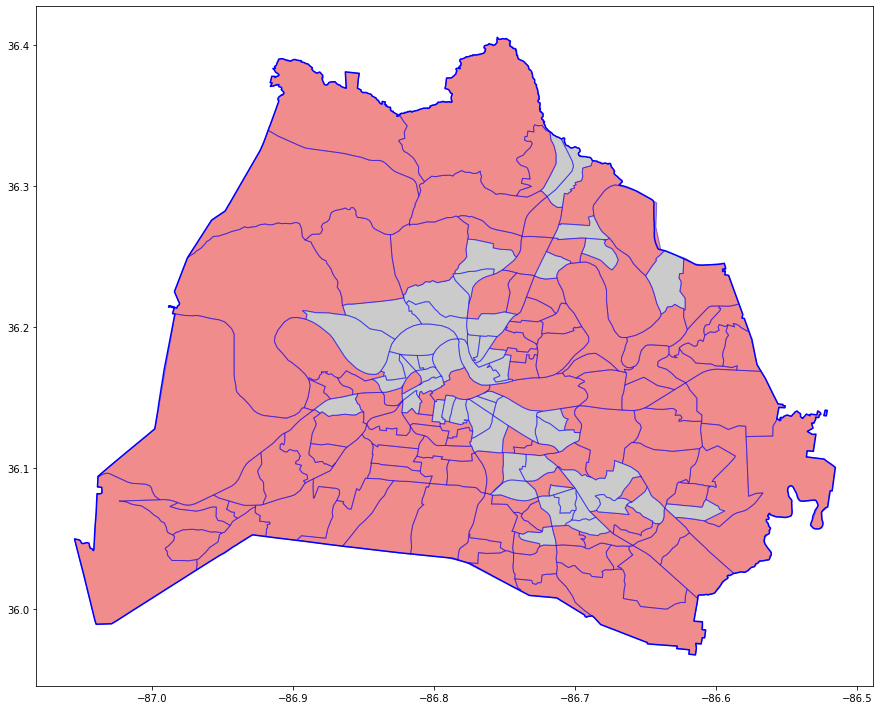

In [28]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = davidson_tracts.plot(ax=ax, column = 'above_20_pct', cmap='Set1', edgecolor = 'blue', alpha = 0.5)
ax = davidson_county.boundary.plot(ax=ax, color='blue')
;

The tracts in **gray** are above 20% poverty, while the ones in **red** are below 20% poverty

## Now we know which tracts have above 20% poverty, we can find stores that sell fresh produce

Finding all the grocery stores that can be accessed by Davidson County residents is a little tough. There are a few lists but they are behind a paywall. For this we'll walk through an example of how the Google Maps API can be used to get Supermarkets and other stores.

Google Maps has many API endpoints, the one we'll use is the `nearbysearch` endpoint. For that we'll need to supply a **coordinate point**, a **radius**, and the **type** of store(s) to search for. The API does have limits so to make sure we are getting all the data we're expecting, we have to break the search down into smaller pieces. 

One important thing to consider is where to search for grocery stores. In general this seems obvious, but we should also consider the (literal) edge cases. For residents living at the edges of Davidson County, a grocery store could be within a mile _outside_ of the county limits. Additionally, the definition of a food desert is different for urban vs. rural areas. Urban areas look for grocery stores within a mile, while rural areas look for grocery stores within _10_ miles. So some additional steps we need to take are:  
1. Determine which census tracts are considered urban vs. rural
2. If there are rural tracts, expand the search area to 10 miles around Davidson County
3. Divide the search area into smaller parts to ensure we capture all the stores

Determining "rural" census tracts is difficult, since urban areas are determined by population level, and census tracts are drawn to have approximately equal population levels. Luckily, Davidson County has outlined the Nashville Urban Services District, so let's start by comparing the urban area with the census tracts:

In [29]:
davidson_service_districts = gpd.read_file('data/Service Districts (GIS).geojson')
davidson_service_districts.crs = "EPSG:4326"
davidson_service_districts

,area_sq_mi,name,objectid,geometry
0,198,Urban Services District,0,"MULTIPOLYGON (((-86.68681 36.28671, -86.68706 ..."
1,327,General Services District,4,"MULTIPOLYGON (((-86.56776 36.03424, -86.56783 ..."


We only want the `Urban Services District`

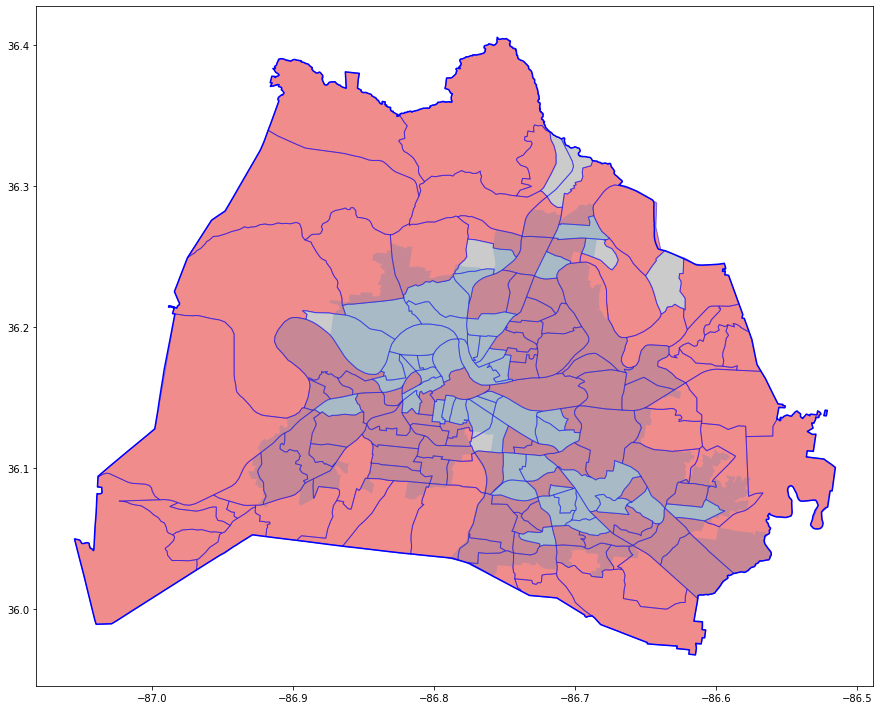

In [30]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = davidson_tracts.plot(ax=ax, column = 'above_20_pct', cmap='Set1', edgecolor = 'blue', alpha = 0.5)
ax = davidson_county.boundary.plot(ax=ax, color='blue')
ax = davidson_service_districts[davidson_service_districts['name']=='Urban Services District'].plot(ax=ax, alpha = 0.2);

The urban area roughly overlaps with census tracts but not fully. For this analysis let's say if at least 50% of the tract is in the urban area, then it is an urban tract.

One good approach to determine if each tract is urban or rural is the `.apply()` method. This method will take a function, and _apply_ it to each row. There is no pre-built function to check if a tract is urban or rural so let's make our own!

Determining how much of a shape overlaps with another is actually relatively straightforward. We can first subtract the urban area from a given tract, which will leave us with the tract area _outside_ of the urban area. Then we can divide that value by the total area of the tract. That will give us the proportion of the tract that is **rural**. We will use the `.area` attribute to work with numeric values. Once we have the ratio, we can determine `True` or `False`, is the ratio greater than 0.5. If it is, then the tract is **rural**

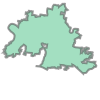

In [34]:
urban_service_area = davidson_service_districts.loc[0, 'geometry']
urban_service_area

In [35]:
def check_urban_tract(row):
    return (row['geometry'] - urban_service_area).area/row['geometry'].area

In [36]:
davidson_tracts['rural_ratio'] = davidson_tracts.apply(check_urban_tract, axis = 1) # axis = 1 means apply to rows

davidson_tracts['is_rural'] = (davidson_tracts['rural_ratio'] > 0.5).astype(int) 

In [37]:
davidson_tracts.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,pct_below_poverty_level,above_20_pct,rural_ratio,is_rural
0,47,037,015625,1400000US47037015625,47037015625,156.25,CT,9544531,1931522,"POLYGON ((-86.65754 36.11937, -86.65558 36.122...",0.140176,0,0.849816,1
1,47,037,016000,1400000US47037016000,47037016000,160,CT,1158914,0,"POLYGON ((-86.77265 36.14987, -86.76948 36.151...",0.222338,1,0.000000,0
2,47,037,017300,1400000US47037017300,47037017300,173,CT,2362363,0,"POLYGON ((-86.75091 36.12039, -86.75051 36.121...",0.170287,0,0.000000,0
3,47,037,018409,1400000US47037018409,47037018409,184.09,CT,3432622,0,"POLYGON ((-86.98225 36.07529, -86.98171 36.075...",0.037373,0,1.000000,1
4,47,037,019106,1400000US47037019106,47037019106,191.06,CT,1853544,0,"POLYGON ((-86.74414 36.04342, -86.74375 36.047...",0.096339,0,0.000000,0


We can see that some tracts are completely urban, others are completely rural, and some are in between. Our threshold of 0.5 seems to be working as expected.

Since there are rural tracts, we know we need to expand our search area, we can do that by creating a new GeoPandas object where a `buffer` is added around the county:

Geopandas buffers are calculated based on the crs of the gdf. Since we are using "EPSG:4326" we know the units are degrees. Using this conversion from the USGS (https://www.usgs.gov/faqs/how-much-distance-does-a-degree-minute-and-second-cover-your-maps?qt-news_science_products=0#qt-news_science_products): "One degree of latitude equals approximately 364,000 feet (69 miles), one minute equals 6,068 feet (1.15 miles), and one-second equals 101 feet." We can approximate the number of degrees in a mile as: 1/69 = 0.014492753623188406

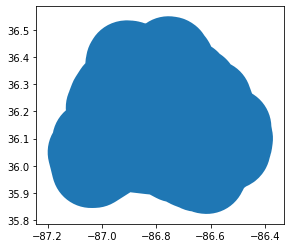

In [38]:
davidson_county_buffer_10 = gpd.GeoDataFrame(geometry = davidson_county['geometry'].buffer(0.14492753623188406),
                                          crs = "EPSG:4326")
davidson_county_buffer_10.plot()

Now we can add a grid to the expanded search area to break the search down into smaller pieces. We can start by finding the absolute x and y boundaries of the search area:

In [39]:
# Find total geographic bounds of search area

xmin,ymin,xmax,ymax =  davidson_county_buffer_10.total_bounds

Based on a little experimentation, a good spacing for the grid points is by dividing the total bounds for Davidson County itself by 10. So let's do that now:

In [40]:
# Find total geographic bounds of Davidson County

xmin_d,ymin_d,xmax_d,ymax_d =  davidson_county.total_bounds

# Divide the length and width by 10 to get the increment between each grid point

x_increment = (xmax_d-xmin_d)/10
y_increment = (ymax_d-ymin_d)/10

Now we can proceed with setting up the search grid:

In [41]:
# determine x coordinate values for grid points
grid_x_boundaries = [xmin]
new_bound = xmin
for i in range(int((xmax-xmin)/x_increment)+1):
    new_bound = new_bound + x_increment
    grid_x_boundaries.append(new_bound)
    
# determine x coordinate values for grid points
grid_y_boundaries = [ymin]
new_bound = ymin
for i in range(int((ymax-ymin)/y_increment)+1):
    new_bound = new_bound + y_increment
    grid_y_boundaries.append(new_bound)

In [42]:
# get list of all lats and lons across all grid points
lons = []
lats = []
for left, right in zip(grid_x_boundaries[:-1], grid_x_boundaries[1:]):
    for top, bottom in zip(grid_y_boundaries[:-1], grid_y_boundaries[1:]):
        lats.append((top+bottom)/2)
        lons.append((left+right)/2)

By converting the coordinate pairs to `point` objects, we can put them into a geodataframe and then we can easily perform a number of geographic calculations.

In [43]:
# Take each pair of longitude and latitude, combine them, and convert to point object
grid_points = gpd.points_from_xy(lons, lats)

In [44]:
# put into geodataframe
grid_gdf = gpd.GeoDataFrame(geometry = grid_points, crs = "EPSG:4326")

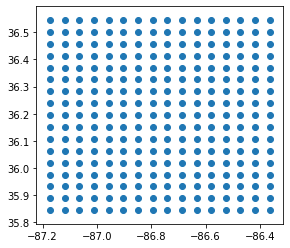

In [45]:
grid_gdf.plot()

The points are forming a grid as we expected. You'll notice that the grid is a square, but our search area is not. Our next step is to keep only the points in our search area. 

In [51]:
# Only keep points within the buffered Davidson county polygon
keep_points = []
for ind, p in grid_gdf['geometry'].iteritems():
    if p.within(davidson_county_buffer_10.loc[0, 'geometry']) or p.within(davidson_county_buffer_10.loc[1, 'geometry']):
        keep_points.append(ind)

grid_points_sub = grid_gdf.loc[keep_points].reset_index(drop=True)

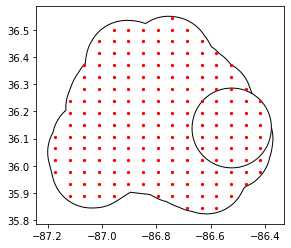

In [52]:
base = davidson_county_buffer_10.plot(color='white', edgecolor='black')

grid_points_sub.plot(ax=base, marker='o', color='red', markersize=5);

We can see that all the points are within the search area. The reason there is an additional circle in the search area is because Davidson County has a part that is disconnected from the main area.

Now that we have all the coordinate points we want to search nearby, we can figure out what an appropriate radius would be. The radius is measured in meters. Measuring distance with lat and lng is a little different since you need to take into consideration the curviture of the earth. To do that we can use the `haversine distance` formula.

In [53]:
# function adapted from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html
def dist_in_meters(point_1, point_2):
    point_1 = [math.radians(l) for l in [point_1.y, point_1.x]]
    point_2 = [math.radians(l) for l in [point_2.y, point_2.x]]
    dist_array_m = haversine_distances([point_1, point_2])*6371000
    return dist_array_m[0][1]

We will select a radius that is the distance between two adjacent points. This will cause some amount of overlap, but it will also maximize the changes a relevant store will be returned, if it is not retured from another point for some reason.

In [55]:
grid_point_radius = dist_in_meters(grid_points_sub.loc[1, 'geometry'], grid_points_sub.loc[2, 'geometry'])

We can visualize the search area for each point on our map to make sure our entire search area is covered.

''

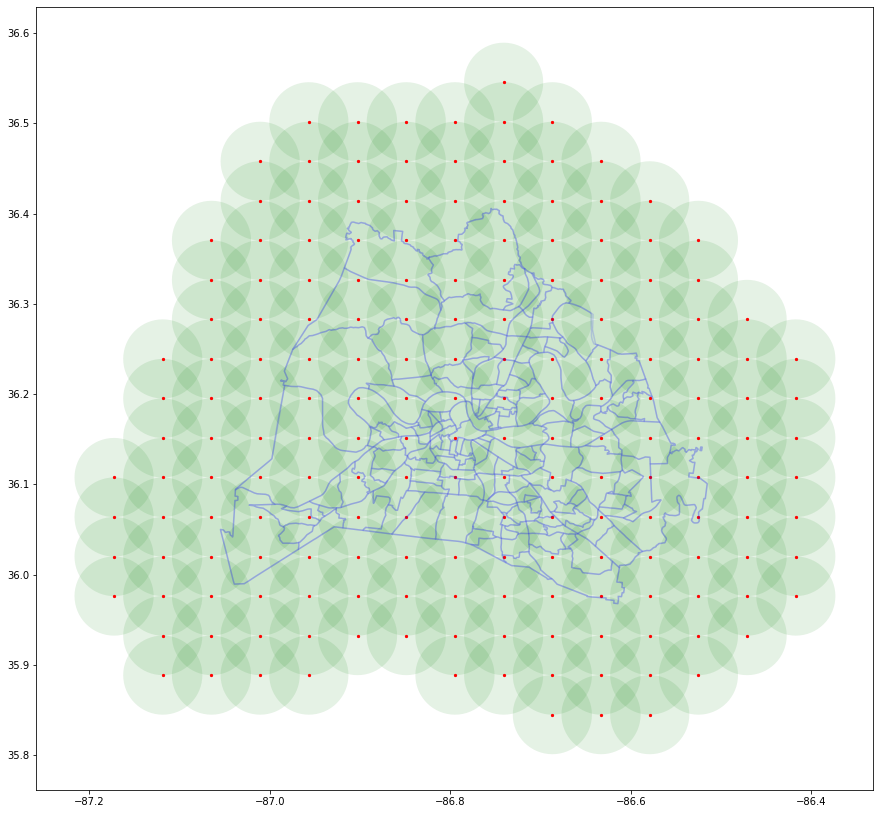

In [56]:
grid_point_radius_mile = 3.0258050367212114828/69
grid_points_sub_buffers = gpd.GeoDataFrame(geometry = grid_points_sub['geometry'].buffer(grid_point_radius_mile),
                                          crs = "EPSG:4326")
f, ax = plt.subplots(1, figsize=(15, 15))
ax = davidson_tracts.boundary.plot(ax=ax, edgecolor = 'blue', color='blue', alpha = 0.15)
ax = davidson_county.boundary.plot(ax=ax, color='blue', alpha = 0.15)
ax = grid_points_sub_buffers.plot(ax=ax, color = 'green', alpha = 0.1)
grid_points_sub.plot(ax=ax, marker='o', color='red', markersize=5)
;

We can see that Davidson County is entirely covered, as well 10 miles surrounding.

## Now with grid points laid out across county we can figure out which types of stores to look for.

Google Maps has a number of business types (https://developers.google.com/places/supported_types). Looking through them, all relevant store types are these:

In [57]:
all_types = ['bakery',
             'convenience_store',
             'department_store',
             'drugstore',
             'gas_station',
             'grocery_or_supermarket',
             'home_goods_store',
             'supermarket',
             'pharmacy']

To fully search for all stores across the entire county we would have to search each grid point for each store type. That will take a very long time. Additionally, it would require setting up an app on google to use for making the API requests. I've already done the run the code but we can walk through the steps for getting the data.

The function for actually making the API calls is here:

In [58]:
# Modified from https://python.gotrained.com/google-places-api-extracting-location-data-reviews/

def search_places_by_coordinate(location, radius, types, api_key, sleep_sec = 2):
    '''
    Send request to nearbysearch Google Maps endpoint
    
    location: The lat and lng to search nearby, "lat, lng"
    radius: The distance, in meters, to search around the location
    types: List of business types to search for
    api_key: Credentials provided by Google to authenticate use of the API
    sleep_sec: Number of seconds to wait between individual requests to throttle and avoid quotas
    '''
    # This is the endpoint where the request will be sent
    endpoint_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    
    places = [] # Where the responses will be saved
    
    # Formatting the request inputs
    params = {
        'location': location,
        'radius': radius,
        'types': types,
        'key': api_key
    }
    
    # Make the request to the endpoint with the associated parameters and save the output
    res = requests.get(endpoint_url, params = params)
    
    # Read the contents of the response, which is a json, into a dictionary to make it easier to work with
    results =  json.loads(res.content)
    
    # Add the results to the any previous results
    places.extend(results['results'])
    
    # Wait before the next request
    time.sleep(sleep_sec)
    
    # If there are still more items available, the response will contain a next_page_token to pick up at the same spot
    # As long as there is a next_page_token, keep making requests
    while "next_page_token" in results:
        params['pagetoken'] = results['next_page_token'],
        res = requests.get(endpoint_url, params = params)
        results = json.loads(res.content)
        places.extend(results['results'])
        time.sleep(sleep_sec)
    
    # Once there are no more next_page_tokens, return the full list of stores
    return places

Since many stores will be returned I created a separate list to add all the responses so they will persist even if there is an issue with a request or there is an interruption for some reason. This will allow me to pick up where it left off

In [59]:
# creating output list in separate cell in case need to run for loop multiple times because of time out errors
responses = []

To systematically search the entire county for all store types I made a nested for loop that will search for each store type across all grid points and append the responses to the master list.

##### This cell will not run since no `api_key` is provided

In [60]:
# This one can take a while, run with caution

for ind_2, t in enumerate(all_types):
    print(ind_2, t) # just to keep track of progress
    # if ind_2 >= 1: # uncomment and tab below over if need to start later in all_types list
    for ind, (lng, lat) in enumerate(list(zip(grid_points_sub['geometry'].x, grid_points_sub['geometry'].y))): # note that lat and lng are switched
        # print(ind, lat, lng) # again, to keep track of progress
        # if ind >= 0: # uncomment and tab below if need to start later in grid df
        location = '{}, {}'.format(lat, lng)
        responses.append(search_places_by_coordinate(location, grid_point_radius, t, api_key))

0 bakery


NameError: name 'api_key' is not defined

After this ran I flattened the response list and saved it off as a csv. Now we can import it again and continue using the data.

In [61]:
stores_df = pd.read_csv('data/google_api_stores_responses_9-4-20_2.csv')
stores_df.head()

,business_status,geometry,icon,id,name,opening_hours,photos,place_id,plus_code,rating,reference,scope,types,user_ratings_total,vicinity,price_level,permanently_closed
0,OPERATIONAL,"{'location': {'lat': 36.078495, 'lng': -87.021...",https://maps.gstatic.com/mapfiles/place_api/ic...,0bb2ffb7088b31394593fc205a6aafbb2390b37e,Twice Daily,{'open_now': True},"[{'height': 4032, 'html_attributions': ['<a hr...",ChIJgWTUPwqPZIgRHtrTgxHr8JU,"{'compound_code': '3XHH+9H Nashville, TN, Unit...",4.0,ChIJgWTUPwqPZIgRHtrTgxHr8JU,GOOGLE,"['convenience_store', 'bakery', 'cafe', 'liquo...",7.0,"8020 Mc Crory Lane, Nashville",NaN,NaN
1,OPERATIONAL,"{'location': {'lat': 36.06422939999999, 'lng':...",https://maps.gstatic.com/mapfiles/place_api/ic...,184b3a540db5d2f81bf1ca8ca03c71568618c907,City Limits Bakery & Cafe,{'open_now': True},"[{'height': 1080, 'html_attributions': ['<a hr...",ChIJnRLxqGOIZIgRph3IUWG16po,"{'compound_code': '3376+M7 Nashville, TN, Unit...",4.5,ChIJnRLxqGOIZIgRph3IUWG16po,GOOGLE,"['restaurant', 'bakery', 'cafe', 'food', 'poin...",291.0,"361 Clofton Drive, Nashville",1.0,NaN
2,OPERATIONAL,"{'location': {'lat': 36.0469637, 'lng': -86.95...",https://maps.gstatic.com/mapfiles/place_api/ic...,7a8ce6b8ac0b5640d864aa08f64d663dcde3a570,Publix Super Market at Harpeth Village,{'open_now': True},"[{'height': 3024, 'html_attributions': ['<a hr...",ChIJa4i9yiiGZIgR1mr9LxMyRUE,"{'compound_code': '22WX+Q6 Nashville, TN, Unit...",4.5,ChIJa4i9yiiGZIgR1mr9LxMyRUE,GOOGLE,"['grocery_or_supermarket', 'bakery', 'liquor_s...",131.0,"8028 Tennessee 100, Nashville",2.0,NaN
3,OPERATIONAL,"{'location': {'lat': 36.0784312, 'lng': -86.94...",https://maps.gstatic.com/mapfiles/place_api/ic...,4815bdf2df59edf504fb5065987808f9b73982c3,Publix Super Market at Bellevue Center,{'open_now': True},"[{'height': 1080, 'html_attributions': ['<a hr...",ChIJH8eunvaIZIgRO7DL3Ok9ayE,"{'compound_code': '33H3+9Q Nashville, TN, Unit...",4.5,ChIJH8eunvaIZIgRO7DL3Ok9ayE,GOOGLE,"['grocery_or_supermarket', 'bakery', 'liquor_s...",336.0,"7604 Highway 70 South, Nashville",2.0,NaN
4,OPERATIONAL,"{'location': {'lat': 36.06422939999999, 'lng':...",https://maps.gstatic.com/mapfiles/place_api/ic...,184b3a540db5d2f81bf1ca8ca03c71568618c907,City Limits Bakery & Cafe,{'open_now': True},"[{'height': 1080, 'html_attributions': ['<a hr...",ChIJnRLxqGOIZIgRph3IUWG16po,"{'compound_code': '3376+M7 Nashville, TN, Unit...",4.5,ChIJnRLxqGOIZIgRph3IUWG16po,GOOGLE,"['restaurant', 'bakery', 'cafe', 'food', 'poin...",291.0,"361 Clofton Drive, Nashville",1.0,NaN


There are a number of useful columns, including the store `name` and `types`. Before we dive into that there's still a little more cleaning we need to do:
1. Remove duplicates (since there is some overlap across the grid points)
2. Extract the lat and lng for each of the stores
3. Only keep stores that are inside Davidson County plus the 1 mile buffer (in case some of the points included areas beyond that area)

We can check to see if there are actually duplicates by using the `.value_counts()` method

In [62]:
stores_df['place_id'].value_counts()

ChIJt3ButpltZIgRnxzB7k5lFLY    16
ChIJv2smpmsVZIgRJwFj8C8KW6o    14
ChIJGQaTwnZEZIgRwJ_srEvhnvg    12
ChIJ13JXvMRvZIgRHbV0lN3BHfU    12
ChIJ5TdvlSdwZIgRnBF4c2XlLvI    12
                               ..
ChIJUSf-MSFEZIgRZrZ7aLLJ_88     1
ChIJIclRU14_ZIgRQPLVP9xf5Kk     1
ChIJ6c__bjxdZIgRDN0Z77tvPMU     1
ChIJ2YL6UjFHZIgRxi1yxNeYvWI     1
ChIJn_oOAnl9ZIgRrKtn5vEduiA     1
Name: place_id, Length: 3384, dtype: int64

There are indeed duplicates, likely due to a combination of stores having multiple store types and being in a place where the search areas overlap.

To remove duplicates we can use the `.drop_duplicates()` method. It will remove duplicate rows and it can be specified to only consider a subset of columns. In our case, we only need to pay attention to the `place_id` column.

In [63]:
stores_df = stores_df.drop_duplicates('place_id')

In [64]:
stores_df['place_id'].value_counts()

ChIJqWUELF5EZIgRouWduxT175w    1
ChIJk1U1rb9gZIgRwleYlTy1LYA    1
ChIJk4v1Hd9GZIgRIvCZNpH6VIc    1
ChIJsxKE64xuZIgRMWoLiHf30WA    1
ChIJh58N48gMZIgRzqHMSQ2L6Wk    1
                              ..
ChIJ8UFKhghxZIgRi0ibsBj7XGI    1
ChIJ3wkWWXFkZIgRP1pV2KEfIw8    1
ChIJ2T0O2x9HZIgRXV_mAjgXXMM    1
ChIJ3QWnrtZjZIgRBdTOW1kDvGo    1
ChIJn_oOAnl9ZIgRrKtn5vEduiA    1
Name: place_id, Length: 3384, dtype: int64

Now we can see the duplicates have been removed

In order to plot the stores on a map we need their lat and lng. That is currently burried in the `geometry` column. Let's take the first row as an example and better understand the structure of the data:

In [65]:
store_location_example = stores_df.loc[0, 'geometry']
print(store_location_example, '\n')
print(type(store_location_example), '\n') # Double check the data type

{'location': {'lat': 36.078495, 'lng': -87.02100899999999}, 'viewport': {'northeast': {'lat': 36.0798680802915, 'lng': -87.01972871970848}, 'southwest': {'lat': 36.07717011970851, 'lng': -87.02242668029149}}} 

<class 'str'> 



It turns out the value in the field is a string, even though it looks like a dictionary. It will be much easier to work with the data if it were a dictionary. Luckily there is a function that converts a string to the actual data type: `literal_eval()` from the `ast` package. Let's use that and verify the change happened as we expected:

In [66]:
store_location_example = ast.literal_eval(store_location_example)
print(type(store_location_example), '\n')
print(store_location_example)

<class 'dict'> 

{'location': {'lat': 36.078495, 'lng': -87.02100899999999}, 'viewport': {'northeast': {'lat': 36.0798680802915, 'lng': -87.01972871970848}, 'southwest': {'lat': 36.07717011970851, 'lng': -87.02242668029149}}}


Looks good! Let's keep going until we have the lat and lng. It looks like it's associated with the `location` key.

In [67]:
lat_lng_example = store_location_example['location']
print(lat_lng_example, '\n')
pd.Series(lat_lng_example)

{'lat': 36.078495, 'lng': -87.02100899999999} 



lat    36.078495
lng   -87.021009
dtype: float64

Once we isolated the lat and lng, since they were in a `dictionary` we can convert it to a `Series` using `pd.Series()`. A single column or row in a DataFrame is a `Series`, and by converting the lat and lng to a `Series` we can easily attach it to another `Series`.

Now we know how to pull out just the lat and lng from the `geometry` column. We can use those to create point objects and put it into a GeoDataFrame to plot all the store locations on a map. We can use `.apply()` again here. So let's make a custom function to extract the lat and lng, create a point object, and then add it to a new column.

In [68]:
def extract_lat_lng_to_new_col(row):
    geo = row['geometry']
    geo = ast.literal_eval(geo)
    lat_lng = geo['location']
    lat_lng_s = pd.Series(lat_lng)
    row = row.append(lat_lng_s)
    return row

In [69]:
# axis = 1 ensures we are applying the function to each row, not each column
stores_df = stores_df.apply(extract_lat_lng_to_new_col, axis = 1)
stores_df.head()

,business_status,geometry,icon,id,name,opening_hours,photos,place_id,plus_code,rating,reference,scope,types,user_ratings_total,vicinity,price_level,permanently_closed,lat,lng
0,OPERATIONAL,"{'location': {'lat': 36.078495, 'lng': -87.021...",https://maps.gstatic.com/mapfiles/place_api/ic...,0bb2ffb7088b31394593fc205a6aafbb2390b37e,Twice Daily,{'open_now': True},"[{'height': 4032, 'html_attributions': ['<a hr...",ChIJgWTUPwqPZIgRHtrTgxHr8JU,"{'compound_code': '3XHH+9H Nashville, TN, Unit...",4.0,ChIJgWTUPwqPZIgRHtrTgxHr8JU,GOOGLE,"['convenience_store', 'bakery', 'cafe', 'liquo...",7.0,"8020 Mc Crory Lane, Nashville",NaN,NaN,36.078495,-87.021009
1,OPERATIONAL,"{'location': {'lat': 36.06422939999999, 'lng':...",https://maps.gstatic.com/mapfiles/place_api/ic...,184b3a540db5d2f81bf1ca8ca03c71568618c907,City Limits Bakery & Cafe,{'open_now': True},"[{'height': 1080, 'html_attributions': ['<a hr...",ChIJnRLxqGOIZIgRph3IUWG16po,"{'compound_code': '3376+M7 Nashville, TN, Unit...",4.5,ChIJnRLxqGOIZIgRph3IUWG16po,GOOGLE,"['restaurant', 'bakery', 'cafe', 'food', 'poin...",291.0,"361 Clofton Drive, Nashville",1.0,NaN,36.064229,-86.939372
2,OPERATIONAL,"{'location': {'lat': 36.0469637, 'lng': -86.95...",https://maps.gstatic.com/mapfiles/place_api/ic...,7a8ce6b8ac0b5640d864aa08f64d663dcde3a570,Publix Super Market at Harpeth Village,{'open_now': True},"[{'height': 3024, 'html_attributions': ['<a hr...",ChIJa4i9yiiGZIgR1mr9LxMyRUE,"{'compound_code': '22WX+Q6 Nashville, TN, Unit...",4.5,ChIJa4i9yiiGZIgR1mr9LxMyRUE,GOOGLE,"['grocery_or_supermarket', 'bakery', 'liquor_s...",131.0,"8028 Tennessee 100, Nashville",2.0,NaN,36.046964,-86.951903
3,OPERATIONAL,"{'location': {'lat': 36.0784312, 'lng': -86.94...",https://maps.gstatic.com/mapfiles/place_api/ic...,4815bdf2df59edf504fb5065987808f9b73982c3,Publix Super Market at Bellevue Center,{'open_now': True},"[{'height': 1080, 'html_attributions': ['<a hr...",ChIJH8eunvaIZIgRO7DL3Ok9ayE,"{'compound_code': '33H3+9Q Nashville, TN, Unit...",4.5,ChIJH8eunvaIZIgRO7DL3Ok9ayE,GOOGLE,"['grocery_or_supermarket', 'bakery', 'liquor_s...",336.0,"7604 Highway 70 South, Nashville",2.0,NaN,36.078431,-86.945505
5,OPERATIONAL,"{'location': {'lat': 36.078712, 'lng': -86.949...",https://maps.gstatic.com/mapfiles/place_api/ic...,ec6ea1b082c7ff0b48270e1737a903119c5c1258,Panera Bread,{'open_now': True},"[{'height': 4032, 'html_attributions': ['<a hr...",ChIJSeRQb_GIZIgRV1KYj1TsY-M,"{'compound_code': '33H2+F7 Nashville, TN, Unit...",4.1,ChIJSeRQb_GIZIgRV1KYj1TsY-M,GOOGLE,"['cafe', 'bakery', 'meal_takeaway', 'restauran...",201.0,"7622 Highway 70 South, Nashville",2.0,NaN,36.078712,-86.949333


Now that the lat and lng are in their own columns we can use the `gpd.points_from_xy()` function to make the `geometry` column that will be used to plot the store locations on the map. First let's change the name of the original `geometry` column so that there isn't any confusion. We can do that using the `.rename()` method again.

In [70]:
stores_df = stores_df.rename(columns = {'geometry': 'geometry_google'})

stores_gdf = gpd.GeoDataFrame(stores_df,
                              geometry = gpd.points_from_xy(stores_df['lng'], # Creating the geometry column
                                                            stores_df['lat']),# on the fly with points_from_xy()
                              crs = "EPSG:4326")

stores_gdf.head()

,business_status,geometry_google,icon,id,name,opening_hours,photos,place_id,plus_code,rating,reference,scope,types,user_ratings_total,vicinity,price_level,permanently_closed,lat,lng,geometry
0,OPERATIONAL,"{'location': {'lat': 36.078495, 'lng': -87.021...",https://maps.gstatic.com/mapfiles/place_api/ic...,0bb2ffb7088b31394593fc205a6aafbb2390b37e,Twice Daily,{'open_now': True},"[{'height': 4032, 'html_attributions': ['<a hr...",ChIJgWTUPwqPZIgRHtrTgxHr8JU,"{'compound_code': '3XHH+9H Nashville, TN, Unit...",4.0,ChIJgWTUPwqPZIgRHtrTgxHr8JU,GOOGLE,"['convenience_store', 'bakery', 'cafe', 'liquo...",7.0,"8020 Mc Crory Lane, Nashville",NaN,NaN,36.078495,-87.021009,POINT (-87.02101 36.07849)
1,OPERATIONAL,"{'location': {'lat': 36.06422939999999, 'lng':...",https://maps.gstatic.com/mapfiles/place_api/ic...,184b3a540db5d2f81bf1ca8ca03c71568618c907,City Limits Bakery & Cafe,{'open_now': True},"[{'height': 1080, 'html_attributions': ['<a hr...",ChIJnRLxqGOIZIgRph3IUWG16po,"{'compound_code': '3376+M7 Nashville, TN, Unit...",4.5,ChIJnRLxqGOIZIgRph3IUWG16po,GOOGLE,"['restaurant', 'bakery', 'cafe', 'food', 'poin...",291.0,"361 Clofton Drive, Nashville",1.0,NaN,36.064229,-86.939372,POINT (-86.93937 36.06423)
2,OPERATIONAL,"{'location': {'lat': 36.0469637, 'lng': -86.95...",https://maps.gstatic.com/mapfiles/place_api/ic...,7a8ce6b8ac0b5640d864aa08f64d663dcde3a570,Publix Super Market at Harpeth Village,{'open_now': True},"[{'height': 3024, 'html_attributions': ['<a hr...",ChIJa4i9yiiGZIgR1mr9LxMyRUE,"{'compound_code': '22WX+Q6 Nashville, TN, Unit...",4.5,ChIJa4i9yiiGZIgR1mr9LxMyRUE,GOOGLE,"['grocery_or_supermarket', 'bakery', 'liquor_s...",131.0,"8028 Tennessee 100, Nashville",2.0,NaN,36.046964,-86.951903,POINT (-86.95190 36.04696)
3,OPERATIONAL,"{'location': {'lat': 36.0784312, 'lng': -86.94...",https://maps.gstatic.com/mapfiles/place_api/ic...,4815bdf2df59edf504fb5065987808f9b73982c3,Publix Super Market at Bellevue Center,{'open_now': True},"[{'height': 1080, 'html_attributions': ['<a hr...",ChIJH8eunvaIZIgRO7DL3Ok9ayE,"{'compound_code': '33H3+9Q Nashville, TN, Unit...",4.5,ChIJH8eunvaIZIgRO7DL3Ok9ayE,GOOGLE,"['grocery_or_supermarket', 'bakery', 'liquor_s...",336.0,"7604 Highway 70 South, Nashville",2.0,NaN,36.078431,-86.945505,POINT (-86.94551 36.07843)
5,OPERATIONAL,"{'location': {'lat': 36.078712, 'lng': -86.949...",https://maps.gstatic.com/mapfiles/place_api/ic...,ec6ea1b082c7ff0b48270e1737a903119c5c1258,Panera Bread,{'open_now': True},"[{'height': 4032, 'html_attributions': ['<a hr...",ChIJSeRQb_GIZIgRV1KYj1TsY-M,"{'compound_code': '33H2+F7 Nashville, TN, Unit...",4.1,ChIJSeRQb_GIZIgRV1KYj1TsY-M,GOOGLE,"['cafe', 'bakery', 'meal_takeaway', 'restauran...",201.0,"7622 Highway 70 South, Nashville",2.0,NaN,36.078712,-86.949333,POINT (-86.94933 36.07871)


One last thing before we can add the stores to the map. We need to remove stores that are outside our area of interest. Since we have a mix of both urban and rural counties, the area of interest will be different for each group. For urban tracts, the area interest is Davidson County plus the 1 mile buffer. For rural tracts, the area of interest is Davidson County plus a 10 mile buffer. We already have the rural area, so let's create the urban area.

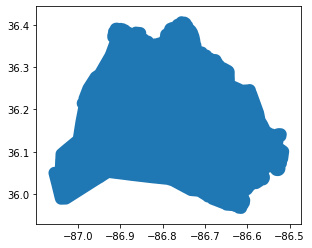

In [71]:
davidson_county_buffer_1 = gpd.GeoDataFrame(geometry = davidson_county['geometry'].buffer(0.014492753623188406),
                                          crs = "EPSG:4326")
davidson_county_buffer_1.plot()

To keep stores within our areas of interest we'll use a different approach from `.apply()`. This time we'll use `.iteritems()` and a for loop.

`.iteritems()` will take each item in a `Series` and perform whatever is inside the for loop. Inside the for loop we are checking if a given point is inside the buffered Davidson County shape. Remember that the county shape actually has two parts that are not directly connected, so we have to check both parts. With that we can keep the stores inside our areas of interest.

To cut down on the number of dfs we have to work with, let's keep all the stores in the rural area, since the urban area is contained within there, and then add a column to indicate if the store is valid for only rural tracts or both

In [72]:
keep_stores = []
rural_only = []
for ind, p in stores_gdf['geometry'].iteritems(): # iteritems gives each index and value as a tuple
    # select stores to keep
    if p.within(davidson_county_buffer_10.loc[0, 'geometry']) or p.within(davidson_county_buffer_10.loc[1, 'geometry']):
        keep_stores.append(ind)
        # indicate if store is rural only or both
        if p.within(davidson_county_buffer_1.loc[0, 'geometry']) or p.within(davidson_county_buffer_1.loc[1, 'geometry']):
            rural_only.append(0)
        else:
            rural_only.append(1)

stores_gdf = stores_gdf.loc[keep_stores]
stores_gdf['rural_only'] = rural_only

In [73]:
stores_gdf.head()

,business_status,geometry_google,icon,id,name,opening_hours,photos,place_id,plus_code,rating,...,scope,types,user_ratings_total,vicinity,price_level,permanently_closed,lat,lng,geometry,rural_only
0,OPERATIONAL,"{'location': {'lat': 36.078495, 'lng': -87.021...",https://maps.gstatic.com/mapfiles/place_api/ic...,0bb2ffb7088b31394593fc205a6aafbb2390b37e,Twice Daily,{'open_now': True},"[{'height': 4032, 'html_attributions': ['<a hr...",ChIJgWTUPwqPZIgRHtrTgxHr8JU,"{'compound_code': '3XHH+9H Nashville, TN, Unit...",4.0,...,GOOGLE,"['convenience_store', 'bakery', 'cafe', 'liquo...",7.0,"8020 Mc Crory Lane, Nashville",NaN,NaN,36.078495,-87.021009,POINT (-87.02101 36.07849),0
1,OPERATIONAL,"{'location': {'lat': 36.06422939999999, 'lng':...",https://maps.gstatic.com/mapfiles/place_api/ic...,184b3a540db5d2f81bf1ca8ca03c71568618c907,City Limits Bakery & Cafe,{'open_now': True},"[{'height': 1080, 'html_attributions': ['<a hr...",ChIJnRLxqGOIZIgRph3IUWG16po,"{'compound_code': '3376+M7 Nashville, TN, Unit...",4.5,...,GOOGLE,"['restaurant', 'bakery', 'cafe', 'food', 'poin...",291.0,"361 Clofton Drive, Nashville",1.0,NaN,36.064229,-86.939372,POINT (-86.93937 36.06423),0
2,OPERATIONAL,"{'location': {'lat': 36.0469637, 'lng': -86.95...",https://maps.gstatic.com/mapfiles/place_api/ic...,7a8ce6b8ac0b5640d864aa08f64d663dcde3a570,Publix Super Market at Harpeth Village,{'open_now': True},"[{'height': 3024, 'html_attributions': ['<a hr...",ChIJa4i9yiiGZIgR1mr9LxMyRUE,"{'compound_code': '22WX+Q6 Nashville, TN, Unit...",4.5,...,GOOGLE,"['grocery_or_supermarket', 'bakery', 'liquor_s...",131.0,"8028 Tennessee 100, Nashville",2.0,NaN,36.046964,-86.951903,POINT (-86.95190 36.04696),0
3,OPERATIONAL,"{'location': {'lat': 36.0784312, 'lng': -86.94...",https://maps.gstatic.com/mapfiles/place_api/ic...,4815bdf2df59edf504fb5065987808f9b73982c3,Publix Super Market at Bellevue Center,{'open_now': True},"[{'height': 1080, 'html_attributions': ['<a hr...",ChIJH8eunvaIZIgRO7DL3Ok9ayE,"{'compound_code': '33H3+9Q Nashville, TN, Unit...",4.5,...,GOOGLE,"['grocery_or_supermarket', 'bakery', 'liquor_s...",336.0,"7604 Highway 70 South, Nashville",2.0,NaN,36.078431,-86.945505,POINT (-86.94551 36.07843),0
5,OPERATIONAL,"{'location': {'lat': 36.078712, 'lng': -86.949...",https://maps.gstatic.com/mapfiles/place_api/ic...,ec6ea1b082c7ff0b48270e1737a903119c5c1258,Panera Bread,{'open_now': True},"[{'height': 4032, 'html_attributions': ['<a hr...",ChIJSeRQb_GIZIgRV1KYj1TsY-M,"{'compound_code': '33H2+F7 Nashville, TN, Unit...",4.1,...,GOOGLE,"['cafe', 'bakery', 'meal_takeaway', 'restauran...",201.0,"7622 Highway 70 South, Nashville",2.0,NaN,36.078712,-86.949333,POINT (-86.94933 36.07871),0


Now that every store has a geometry point associated with it, let's add them all to our map!

''

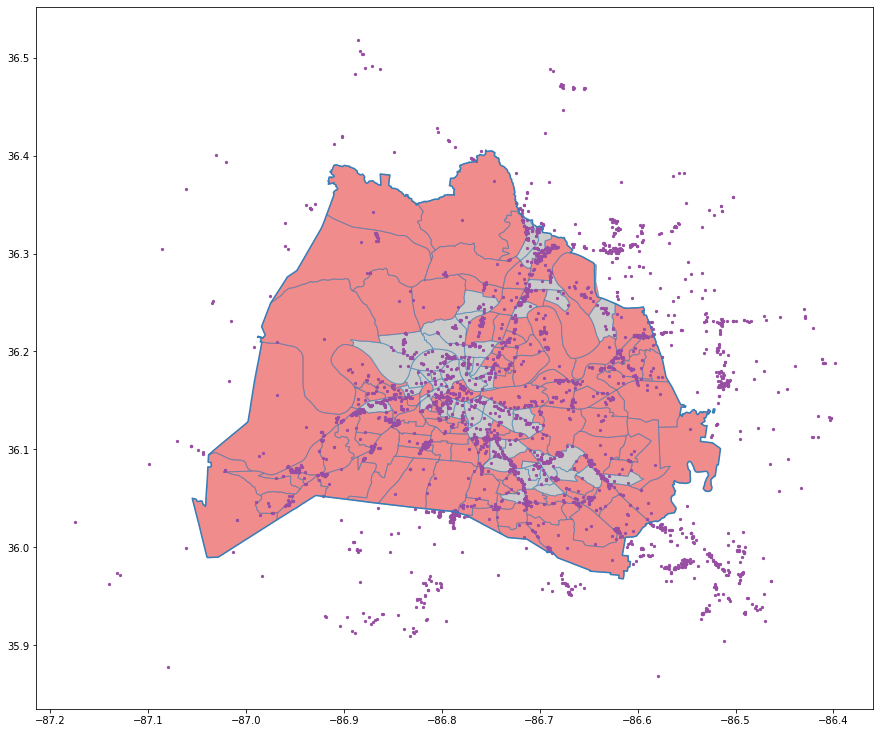

In [75]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = davidson_tracts.plot(ax=ax, column = 'above_20_pct', categorical = True, cmap = 'Set1', edgecolor = '#377eb8', alpha = 0.5)
ax = davidson_county.boundary.plot(ax=ax, color='#377eb8')
stores_gdf.plot(ax=ax, marker='o', color='#984ea3', markersize=5)
;

## Now that we've added the stores to the map we can start to see areas with many stores and areas with few stores, and how those compare to tracts above and below 20% poverty

However they may still be some cleaning we should do, as not all of the stores may actually offer fresh food. Looking at the first few rows of `stores_df`, we can see a **Twice Daily** and a **Panera Bread**, which aren't actually what we want. Let's try and filter down our stores to just ones that are classified as `supermarket`s:

In [76]:
supermarkets = stores_gdf[stores_df['types'].apply(lambda x: 'supermarket' in x)]

/Users/maheshrao/anaconda3/lib/python3.6/site-packages/geopandas/geodataframe.py:546: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


Above we are combining a few techniques. We are filtering the rows in `stores_df` based on the criteria inside the outer `[]`. We are `apply`ing the criteria to the contents of the `types` column. The `lambda` function is how we're determining which rows we want.

A `lambda` function is an `anonomyous` function, meaning it is not given a name or saved to the environment, instead it is created and used on the fly. Since it is created on the fly, it tends to be more abstract. In this case the function takes one argument `x`, and checks to see if `'supermarket'` is in `x`. Though it isn't explicitally stated, the `lambda` function will return what ever the final output is, in this case a `True` or `False`. As before, we are applying this function to each row in the `types` column, so we will get back a `True` or `False` for each row in the df and keep only the `True` rows.

In [77]:
supermarkets

,business_status,geometry_google,icon,id,name,opening_hours,photos,place_id,plus_code,rating,...,scope,types,user_ratings_total,vicinity,price_level,permanently_closed,lat,lng,geometry,rural_only
2,OPERATIONAL,"{'location': {'lat': 36.0469637, 'lng': -86.95...",https://maps.gstatic.com/mapfiles/place_api/ic...,7a8ce6b8ac0b5640d864aa08f64d663dcde3a570,Publix Super Market at Harpeth Village,{'open_now': True},"[{'height': 3024, 'html_attributions': ['<a hr...",ChIJa4i9yiiGZIgR1mr9LxMyRUE,"{'compound_code': '22WX+Q6 Nashville, TN, Unit...",4.5,...,GOOGLE,"['grocery_or_supermarket', 'bakery', 'liquor_s...",131.0,"8028 Tennessee 100, Nashville",2.0,NaN,36.046964,-86.951903,POINT (-86.95190 36.04696),0
3,OPERATIONAL,"{'location': {'lat': 36.0784312, 'lng': -86.94...",https://maps.gstatic.com/mapfiles/place_api/ic...,4815bdf2df59edf504fb5065987808f9b73982c3,Publix Super Market at Bellevue Center,{'open_now': True},"[{'height': 1080, 'html_attributions': ['<a hr...",ChIJH8eunvaIZIgRO7DL3Ok9ayE,"{'compound_code': '33H3+9Q Nashville, TN, Unit...",4.5,...,GOOGLE,"['grocery_or_supermarket', 'bakery', 'liquor_s...",336.0,"7604 Highway 70 South, Nashville",2.0,NaN,36.078431,-86.945505,POINT (-86.94551 36.07843),0
23,OPERATIONAL,"{'location': {'lat': 36.09744999999999, 'lng':...",https://maps.gstatic.com/mapfiles/place_api/ic...,a9b8d6bd8bced8ed94fe5782e03aea619c6bfd56,Harris Teeter,{'open_now': True},NaN,ChIJSfJUilliZIgRXHEaXc6mx-4,"{'compound_code': '34WG+XG Nashville, TN, Unit...",5.0,...,GOOGLE,"['grocery_or_supermarket', 'bakery', 'supermar...",3.0,"6002 Tennessee 100, Nashville",NaN,NaN,36.097450,-86.873639,POINT (-86.87364 36.09745),0
30,OPERATIONAL,"{'location': {'lat': 36.1402176, 'lng': -86.88...",https://maps.gstatic.com/mapfiles/place_api/ic...,ce5ddd2ffed9fe6f2f3f902d5181cbeb00e312ee,Publix Super Market at Hill Center at Nashvill...,{'open_now': True},"[{'height': 2976, 'html_attributions': ['<a hr...",ChIJbSHs2IphZIgRVNJFmBoOn3c,"{'compound_code': '44R8+3R Nashville, TN, Unit...",4.5,...,GOOGLE,"['grocery_or_supermarket', 'bakery', 'liquor_s...",375.0,"6614 Charlotte Pike, Nashville",2.0,NaN,36.140218,-86.882910,POINT (-86.88291 36.14022),0
64,OPERATIONAL,"{'location': {'lat': 36.1267272, 'lng': -86.84...",https://maps.gstatic.com/mapfiles/place_api/ic...,b756b6c3506bfdc60533a9cdaf783c67aebf2982,Publix Super Market at Hill Center at Belle Meade,{'open_now': True},"[{'height': 2268, 'html_attributions': ['<a hr...",ChIJ_98e89xjZIgRkX7e3TmFvyw,"{'compound_code': '45G2+MX Nashville, TN, Unit...",4.4,...,GOOGLE,"['grocery_or_supermarket', 'bakery', 'liquor_s...",316.0,"4324 Harding Pike, Nashville",2.0,NaN,36.126727,-86.847506,POINT (-86.84751 36.12673),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9657,NaN,"{'location': {'lat': 36.23479999999999, 'lng':...",https://maps.gstatic.com/mapfiles/place_api/ic...,NaN,Dollar General,NaN,"[{'height': 720, 'html_attributions': ['<a hre...",ChIJYz6QlZc_ZIgR-MGKa5HTT8k,"{'compound_code': '6FMC+W6 Mt. Juliet, TN, USA...",NaN,...,GOOGLE,"['grocery_or_supermarket', 'home_goods_store',...",NaN,"280 Nonaville Road, Mt. Juliet",NaN,NaN,36.234800,-86.529400,POINT (-86.52940 36.23480),1
9663,OPERATIONAL,"{'location': {'lat': 36.3195465, 'lng': -86.57...",https://maps.gstatic.com/mapfiles/place_api/ic...,NaN,Dollar General,{'open_now': False},"[{'height': 3264, 'html_attributions': ['<a hr...",ChIJG6lnMjZHZIgRK2LAGxayQD4,"{'compound_code': '8C9C+RW Hendersonville, TN,...",4.4,...,GOOGLE,"['grocery_or_supermarket', 'home_goods_store',...",99.0,"104 Brittan Street, Hendersonville",1.0,NaN,36.319547,-86.577736,POINT (-86.57774 36.31955),1
9706,OPERATIONAL,"{'location': {'lat': 35.9245326, 'lng': -86.46...",https://maps.gstatic.com/mapfiles/place_api/ic...,NaN,Dollar General,{'open_now': True},"[{'height': 4032, 'html_attributions': ['<a hr...",ChIJEeecuEgJZIgR2zQHePxe0OI,"{'compound_code': 'WGFJ+R5 Murfreesboro, TN, U...",4.1,...,GOOGLE,"['grocery_or_supermarke

We can see that only keeping rows that have a `type` of `'supermarket'`, greatly reduces the number of stores. Also, in general this seems to be filtering how we want it to filter (we can see many **Publix** stores), but we can also see things that maybe shouldn't be there (like **Dollar General**). 

The influence of dollar stores on food deserts is an area if interest (https://www.cbsnews.com/news/dollar-stores-and-food-deserts-the-latest-struggle-between-main-street-and-corporate-america/). Though some sources indicate that they do not sell fresh produce, the Dollar General website indicates that produce is available in their stores (https://www.dollargeneral.com/catalogsearch/result/?q=produce) but there is no category for fresh foods (https://www.dollargeneral.com/food.html).

For this analysis we will exclude dollar stores from the _stores selling fresh food_ category. That means we will need to remove them from our list.

In [78]:
non_dollar_supermarkets = supermarkets[~supermarkets['name'].str.contains('Dollar')]

Here we are again filtering our data, this time paying attention to the `name` column and identifying rows if the word `Dollar` is in the name. Since `name` contains only text objects, called _strings_, we have to use a _string_ function to search within it. This is why we need to search the `name` column using the method `.str.contains()`. The `~` reverses the True/False so the rows that originally returned False are kept, meaning we will keep everything that does not have `Dollar` in the name.

For completeness, let's double check the non-supermarkets to make sure we're not leaving anything we want behind. We can again use the `~` approach:

In [79]:
non_supermarkets = stores_gdf[~stores_df['types'].apply(lambda x: 'supermarket' in x)]

/Users/maheshrao/anaconda3/lib/python3.6/site-packages/geopandas/geodataframe.py:546: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


In [80]:
non_supermarkets['name'].value_counts()

Shell                                        94
Walgreens                                    66
MAPCO Mart                                   48
Walgreens Pharmacy                           38
Twice Daily                                  37
                                             ..
Aditi Sindhal, PharmD                         1
Jack Gavin                                    1
Black Friday, every day appliances @ more     1
Marathon Southern Hill Market                 1
Green Hills Pharmacy                          1
Name: name, Length: 2093, dtype: int64

A little investigation would show that a slight concern is **Kroger** is in the `non-supermarkets` list. Let's double check to see if **Kroger** is included in the `supermarkets` df.

In [81]:
non_dollar_supermarkets[non_dollar_supermarkets['name'].str.contains('Kroger')]

,business_status,geometry_google,icon,id,name,opening_hours,photos,place_id,plus_code,rating,...,scope,types,user_ratings_total,vicinity,price_level,permanently_closed,lat,lng,geometry,rural_only
7775,OPERATIONAL,"{'location': {'lat': 36.307608, 'lng': -86.600...",https://maps.gstatic.com/mapfiles/place_api/ic...,28e8ba75c4d40af6fe4169338606cbba175b49be,Kroger,{'open_now': True},"[{'height': 1440, 'html_attributions': ['<a hr...",ChIJB33xAjZHZIgRurhw2YLm-_0,"{'compound_code': '895X+2P Hendersonville, TN,...",4.3,...,GOOGLE,"['grocery_or_supermarket', 'supermarket', 'foo...",818.0,"237 East Main Street, Hendersonville",2.0,NaN,36.307608,-86.600724,POINT (-86.60072 36.30761),1


There is one **Kroger**, but that means we are likely missing many others. Let's get the **Kroger** stores and add them back to the `supermarkets` list.

In [82]:
kroger = stores_gdf[stores_df['name'].str.contains('Kroger')]

non_dollar_supermarkets = non_dollar_supermarkets.append(kroger)

non_dollar_supermarkets.tail()

/Users/maheshrao/anaconda3/lib/python3.6/site-packages/geopandas/geodataframe.py:546: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


,business_status,geometry_google,icon,id,name,opening_hours,photos,place_id,plus_code,rating,...,scope,types,user_ratings_total,vicinity,price_level,permanently_closed,lat,lng,geometry,rural_only
8740,OPERATIONAL,"{'location': {'lat': 36.22929490000001, 'lng':...",https://maps.gstatic.com/mapfiles/place_api/ic...,NaN,Kroger Bakery,NaN,NaN,ChIJG2GHIxQ-ZIgRXM5XZ-GhBeM,"{'compound_code': '6FHM+PF Mt. Juliet, TN, USA...",NaN,...,GOOGLE,"['bakery', 'food', 'point_of_interest', 'store...",NaN,"4120 North Mount Juliet Road, Mt. Juliet",2.0,NaN,36.229295,-86.516351,POINT (-86.51635 36.22929),1
9235,OPERATIONAL,"{'location': {'lat': 36.2293954, 'lng': -86.51...",https://maps.gstatic.com/mapfiles/place_api/ic...,NaN,Kroger Fuel Center,{'open_now': True},"[{'height': 270, 'html_attributions': ['<a hre...",ChIJG2GHIxQ-ZIgRYIhGECFBuxY,"{'compound_code': '6FHP+Q2 Mt. Juliet, TN, USA...",4.6,...,GOOGLE,"['gas_station', 'point_of_interest', 'establis...",48.0,"4120 North Mount Juliet Road, Mt. Juliet",2.0,NaN,36.229395,-86.514915,POINT (-86.51491 36.22940),1
9246,OPERATIONAL,"{'location': {'lat': 36.1647975, 'lng': -86.51...",https://maps.gstatic.com/mapfiles/place_api/ic...,NaN,Kroger Fuel Center,{'open_now': True},"[{'height': 270, 'html_attributions': ['<a hre...",ChIJQ13fcjIUZIgRnEK3DWXiF9w,"{'compound_code': '5F7P+WF Mt. Juliet, TN, USA...",3.7,...,GOOGLE,"['gas_station', 'point_of_interest', 'establis...",11.0,"401 South Mount Juliet Road, Mt. Juliet",2.0,NaN,36.164797,-86.513793,POINT (-86.51379 36.16480),1
9269,OPERATIONAL,"{'location': {'lat': 36.3444057, 'lng': -86.52...",https://maps.gstatic.com/mapfiles/place_api/ic...,NaN,Kroger Fuel Center,{'open_now': True},"[{'height': 270, 'html_attributions': ['<a hre...",ChIJjfxxXac5ZIgRizjlY888fX8,"{'compound_code': '8FVF+Q2 Gallatin, TN, USA',...",4.4,...,GOOGLE,"['gas_station', 'point_of_interest', 'establis...",110.0,"2011 Nashville Pike, Gallatin",2.0,NaN,36.344406,-86.527442,POINT (-86.52744 36.34441),1
9951,OPERATIONAL,"{'location': {'lat': 36.2293805, 'lng': -86.51...",https://maps.gstatic.com/mapfiles/place_api/ic...,NaN,Kroger Pharmacy,{'open_now': False},"[{'height': 270, 'html_attributions': ['<a hre...",ChIJl91VRBE-ZIgRshTizrx3Jx8,"{'compound_code': '6FHM+QC Mt. Juliet, TN, USA...",3.4,...,GOOGLE,"['pharmacy', 'health', 'point_of_interest', 's...",8.0,"4120 North Mount Juliet Road, Mt. Juliet",2.0,NaN,36.229380,-86.516398,POINT (-86.51640 36.22938),1


With that cleaning done, let's plot the supermarkets on the map and see where we stand now:

''

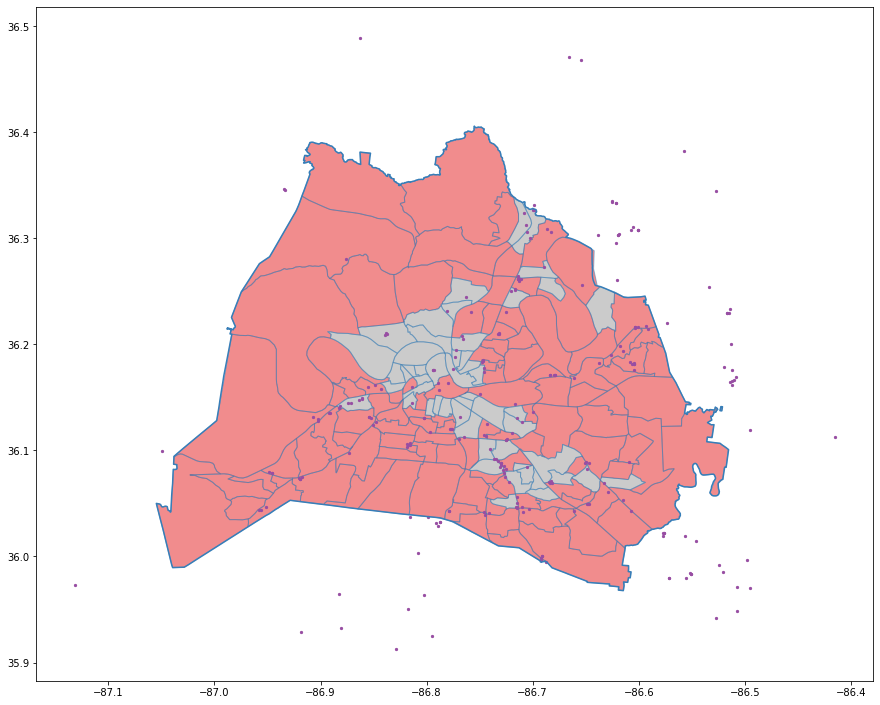

In [83]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = davidson_tracts.plot(ax=ax, column = 'above_20_pct', categorical = True, cmap = 'Set1', edgecolor = '#377eb8', alpha = 0.5)
ax = davidson_county.boundary.plot(ax=ax, color='#377eb8')
non_dollar_supermarkets.plot(ax=ax, marker='o', color='#984ea3', markersize=5)
;

There are far fewer now, but the spread seems similar.

Farmers Markets are places where fresh food is available but is often overlooked. `Pick Tennessee` luckily has a list of all the farmers markets. We can use webscraping to get that information and add it to our data. Let's start by taking a look at the `Pick Tennessee` website: https://www.picktnproducts.org/listview/farmers-market.html

The website has all the information we need. Scraping the website is very similar to making an API call. The first thing we need is the endpoint url, which is the website itself

In [84]:
url = 'https://www.picktnproducts.org/listview/farmers-market.html'

Now with the url, we can make a `GET` request, which will go out and grab all the info off the site. 

In [85]:
response = requests.get(url)

As we saw when we viewed the page source, html is messy and difficult to traverse. Luckly, there's a package for that. BeautifulSoup can take the html and parse it, making it easier for us to grab the pieces we want. In this case it is parsing using an `lxml` parser.

In [86]:
soup = BS(response.content, 'lxml')

Now that it is parsed and saved into the variable `soup` we can pull out the pieces we want. The top level pieces is the object with the `id` of `middle`

In [87]:
markets_names_soup = soup.find_all('div', attrs = {'id': 'middle'})

In [ ]:
markets_names_soup

In [89]:
type(markets_names_soup)

bs4.element.ResultSet

This is an intimidating mess but let's just look at the very beginning instead of trying to understand all of it at once. Even though the `type` is a `ResultSet`, the first character of the object is a `[`, which looks like the beginning of a list. So let's test that by **indexing** into the object to take just the first element.

In [ ]:
markets_names_soup[0]

OK, that worked! Now we can see there is something called a `div` at the beginning followed by `data-middlejson` and more stuff. Let's see what other information we can learn about the object.

In [91]:
print(type(markets_names_soup[0]))
print(markets_names_soup[0].name)

<class 'bs4.element.Tag'>
div


The first item inside the top object is a `Tag` and the name of the `Tag` is `div`. Since `div` is the name of the `Tag` maybe `data-middlejson` is a part of the `Tag` that we can index into

In [ ]:
markets_names_soup[0]['data-middlejson']

OK, getting closer! We can see that there is an opening quote, indicating a string, and a `[` indicating a list. Inside there is all the information we actully want. Let's try to use ast.literal_eval to get convert the string into an actual list

In [ ]:
ast.literal_eval(markets_names_soup[0]['data-middlejson'])

Now we have something we can work with! A list of dictionaries is something that pandas can easily parse. Let't try putting this into a DataFrame.

In [94]:
mid_tn_farm_mark = pd.DataFrame(ast.literal_eval(markets_names_soup[0]['data-middlejson']))
mid_tn_farm_mark.head()

,id,storeLogoPath,storeName,storeAddress,storeTeleNo,storeRegion,latitude,longitude,storeCounty,socialMediaList,hidePhysicalAddress
0,896,/content/dam/headers/logo_s.png,Fayetteville Farmers Market,"421 Lincoln Avenue South, Fayetteville, TN 37334",931-433-6059,Middle,35.148413,-86.572802,Lincoln,[],NaN
1,902,/content/dam/headers/logo_s.png,Livingston-Overton County Farmers Market,"Corner of University & Spring Streets, Livings...",931-823-1269,Middle,0.000000,0.000000,Overton,[],NaN
2,15541,/content/dam/headers/logo_s.png,La Vergne Farmers Market,"294 Sand Hill Road, La Vergne, TN 37086",615-793-3224,Middle,36.023672,-86.560037,Rutherford,[{'link': 'https://www.facebook.com/LaVergneFa...,0
3,3689,/content/dam/headers/logo_s.png,Fentress County Farmers Market located at the ...,"452 E. Mark Twain Avenue, Jamestown, TN 38556",931-879-8212,Middle,36.427785,-84.924734,Fentress,[],NaN
4,2823,/content/dam/headers/logo_s.png,Nashville Farmers' Market at VUMC,"2211 Garland Avenue, Nashville, TN 37212",615-880-2001,Middle,36.142760,-86.802316,Davidson,[],NaN


Success! We've successfully extracted the farmers market data into a usable format. And there is also a `latitude` and `longitude` column! There are some that we won't need since they are outside of Davidson. We can't strictly rely on the `storeCounty` column, since there may be a Farmers Market that is just outside of Davidson but still within 10 miles. Let's add a point geometry column and then keep all the markets that are within it.

In [95]:
mid_tn_farm_mark = gpd.GeoDataFrame(mid_tn_farm_mark,
                                    geometry = gpd.points_from_xy(mid_tn_farm_mark['longitude'], mid_tn_farm_mark['latitude']),
                                    crs = "EPSG:4326")

keep_points_fm = []
rural_only_fm = []
for ind, p in mid_tn_farm_mark['geometry'].iteritems():
    if p.within(davidson_county_buffer_10.loc[0, 'geometry']) or p.within(davidson_county_buffer_10.loc[1, 'geometry']):
        keep_points_fm.append(ind)
        if p.within(davidson_county_buffer_1.loc[0, 'geometry']) or p.within(davidson_county_buffer_1.loc[1, 'geometry']):
            rural_only_fm.append(0)
        else:
            rural_only_fm.append(1)

davidson_farm_mark = mid_tn_farm_mark.loc[keep_points_fm]
davidson_farm_mark['rural_only'] = rural_only_fm

davidson_farm_mark.head()

,id,storeLogoPath,storeName,storeAddress,storeTeleNo,storeRegion,latitude,longitude,storeCounty,socialMediaList,hidePhysicalAddress,geometry,rural_only
2,15541,/content/dam/headers/logo_s.png,La Vergne Farmers Market,"294 Sand Hill Road, La Vergne, TN 37086",615-793-3224,Middle,36.023672,-86.560037,Rutherford,[{'link': 'https://www.facebook.com/LaVergneFa...,0,POINT (-86.56004 36.02367),0
4,2823,/content/dam/headers/logo_s.png,Nashville Farmers' Market at VUMC,"2211 Garland Avenue, Nashville, TN 37212",615-880-2001,Middle,36.142760,-86.802316,Davidson,[],NaN,POINT (-86.80232 36.14276),0
5,3538,/content/dam/headers/logo_s.png,Nolensville Farmers Market,"7248 Nolensville Road, Nolensville, TN 37135",931-284-9295,Middle,35.959812,-86.673035,Williamson,[{'link': 'https://www.facebook.com/pages/Nole...,NaN,POINT (-86.67303 35.95981),1
6,3621,/content/dam/headers/logo_s.png,Kingston Springs Farmers & Artisans Market,"147 Harpeth View Trail , Kingston Springs, TN ...",615-415-2200,Middle,36.089107,-87.096442,Cheatham,[{'link': 'https://www.facebook.com/KSFarmersM...,NaN,POINT (-87.09644 36.08911),1
7,10034,/content/dam/headers/logo_s.png,White House Farmers Market,"105-C College Street , White House, TN 37188",615-672-4350,Middle,36.468107,-86.652607,Sumner,[{'link': 'https://www.facebook.com/WHFarmersM...,0,POINT (-86.65261 36.46811),1


We can add these to our map as well

''

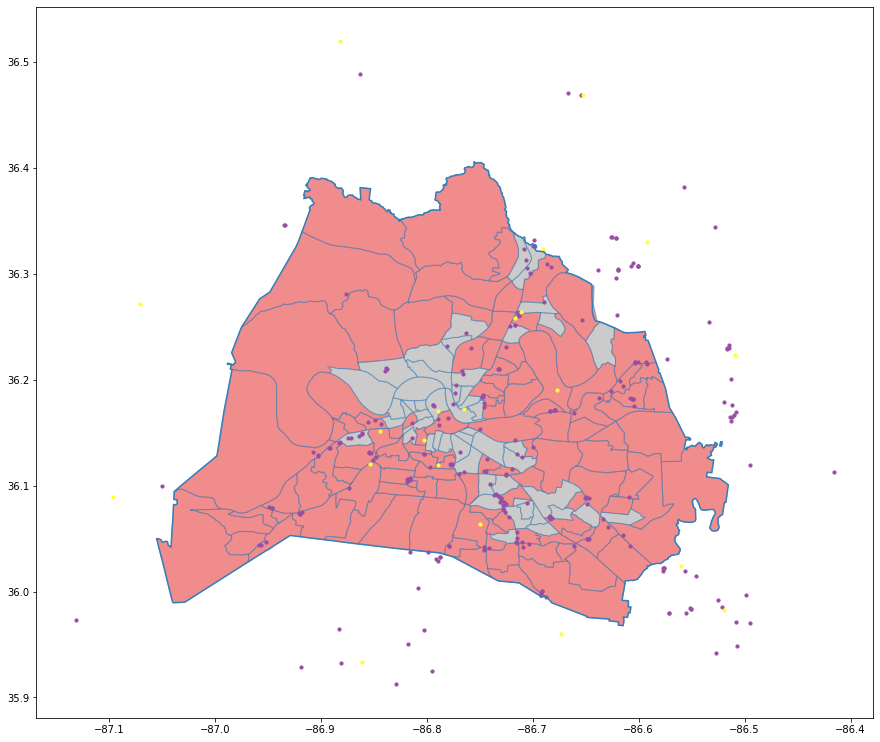

In [96]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = davidson_tracts.plot(ax=ax, column = 'above_20_pct', categorical = True, cmap = 'Set1', edgecolor = '#377eb8', alpha = 0.5)
ax = davidson_county.boundary.plot(ax=ax, color='#377eb8')
ax = non_dollar_supermarkets.plot(ax=ax, marker='o', color='#984ea3', markersize=10)
davidson_farm_mark.plot(ax=ax, marker='o', color='#ffff33', markersize=10)
;

## Now that we have a list of stores that sell fresh food, we can find the low income census tracts where at least a third is more than a mile (or 10 miles for rural tracts) away from them.

To address that we will add buffers around the stores that correspond to a 1 mile radius.

The buffers will be separate objects, so we will create a new gdf for them. Recall that we can approximate the number of degrees in a mile as: 1/69 = 0.014492753623188406

In [97]:
urban_store_buffers = gpd.GeoDataFrame(geometry = non_dollar_supermarkets[non_dollar_supermarkets['rural_only']==0]['geometry'].buffer(0.014492753623188406),
                                          crs = "EPSG:4326")
urban_store_buffers = urban_store_buffers.append(
    gpd.GeoDataFrame(
        geometry = davidson_farm_mark[davidson_farm_mark['rural_only']==0]['geometry'].buffer(0.014492753623188406),
        crs = "EPSG:4326"))

rural_store_buffers = gpd.GeoDataFrame(geometry = non_dollar_supermarkets['geometry'].buffer(0.14492753623188406),
                                          crs = "EPSG:4326")
rural_store_buffers = rural_store_buffers.append(
    gpd.GeoDataFrame(
        geometry = davidson_farm_mark['geometry'].buffer(0.14492753623188406),
        crs = "EPSG:4326"))

We will not add buffers for a 10 mile radius since those will obscure much of the map. 

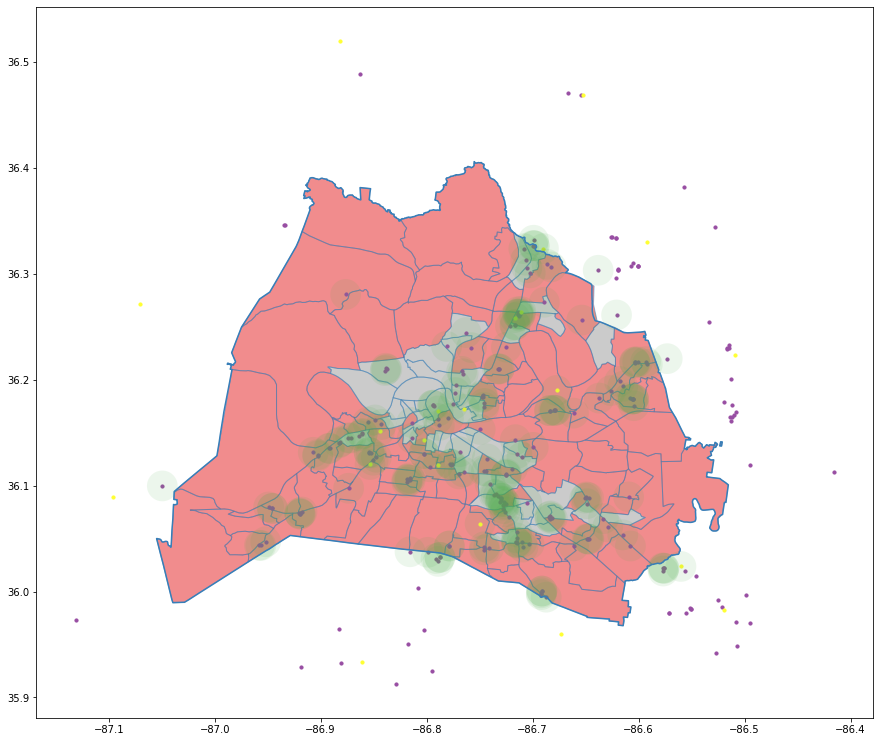

In [98]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = davidson_tracts.plot(ax=ax, column = 'above_20_pct', categorical = True, cmap = 'Set1', edgecolor = '#377eb8', alpha = 0.5)
ax = davidson_county.boundary.plot(ax=ax, color='#377eb8')
ax = non_dollar_supermarkets.plot(ax=ax, marker='o', color='#984ea3', markersize=10)
ax = davidson_farm_mark.plot(ax=ax, marker='o', color='#ffff33', markersize=10)
urban_store_buffers.plot(ax=ax, color = '#4daf4a', alpha = 0.1)

At this point we can start to see with more clarity where the food deserts actually are. To really nail it down, let's calculate the exact proportion of each census tract that is too far away from a fresh food source.

There are many ways we can accomplish this, but an easy way is to combine all the store buffers into a single shape, then check the proportion of each tract that overlaps with that shape. Since we are differentiating rural and urban tracts, let's also make different store buffers to check against.

To combine the buffer shapes, we can use the `unary_union()` function:

In [99]:
urban_store_buffers = unary_union(urban_store_buffers['geometry'])
rural_store_buffers = unary_union(rural_store_buffers['geometry'])

Luckily calculating the amount of overlap of two polygons is fairly straight forward

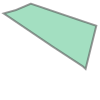

In [100]:
# First take a census tract
davidson_tracts[davidson_tracts['is_rural']==0].loc[1, 'geometry']

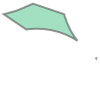

In [101]:
# Subtract the shape made from combining all the store buffers
davidson_tracts[davidson_tracts['is_rural']==0].loc[1, 'geometry'] - urban_store_buffers

In [102]:
# Get the numeric area value
(davidson_tracts[davidson_tracts['is_rural']==0].loc[1, 'geometry'] - urban_store_buffers).area

4.394839864132709e-05

In [103]:
# Divide by the total area of the tract
(davidson_tracts[davidson_tracts['is_rural']==0].loc[1, 'geometry'] - urban_store_buffers).area/davidson_tracts[davidson_tracts['is_rural']==0].loc[1, 'geometry'].area

0.3784439222616482

For the census tract in row 2 of the census tract df, 38% is more than a mile from a fresh food source, indicating it has low food access.

We can make these calculations into a function to more easily check a census tract:

In [104]:
def check_low_food_access(row):
    if row['is_rural'] == 1:
        return (row['geometry'] - rural_store_buffers).area/row['geometry'].area
    else:
        return (row['geometry'] - urban_store_buffers).area/row['geometry'].area

In [108]:
# check tract on row 3 of census tract df
check_low_food_access(davidson_tracts.loc[2, :])

0.0

The entire tract on row 3 of the census tract df is within a mile of a fresh food source, indicating it does not have low food access.

Let's expand this out to find all the possible food deserts in Davidson County

In [106]:
davidson_tracts['ratio_low_food_access'] = davidson_tracts.apply(check_low_food_access, axis = 1)

davidson_tracts['possible_food_desert'] = ((davidson_tracts['ratio_low_food_access'] > 0.33) & (davidson_tracts['above_20_pct'] == 1)).astype(int)

In [109]:
davidson_tracts.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,pct_below_poverty_level,above_20_pct,rural_ratio,is_rural,ratio_low_food_access,possible_food_desert
0,47,037,015625,1400000US47037015625,47037015625,156.25,CT,9544531,1931522,"POLYGON ((-86.65754 36.11937, -86.65558 36.122...",0.140176,0,0.849816,1,0.000000,0
1,47,037,016000,1400000US47037016000,47037016000,160,CT,1158914,0,"POLYGON ((-86.77265 36.14987, -86.76948 36.151...",0.222338,1,0.000000,0,0.378444,1
2,47,037,017300,1400000US47037017300,47037017300,173,CT,2362363,0,"POLYGON ((-86.75091 36.12039, -86.75051 36.121...",0.170287,0,0.000000,0,0.000000,0
3,47,037,018409,1400000US47037018409,47037018409,184.09,CT,3432622,0,"POLYGON ((-86.98225 36.07529, -86.98171 36.075...",0.037373,0,1.000000,1,0.000000,0
4,47,037,019106,1400000US47037019106,47037019106,191.06,CT,1853544,0,"POLYGON ((-86.74414 36.04342, -86.74375 36.047...",0.096339,0,0.000000,0,0.000000,0


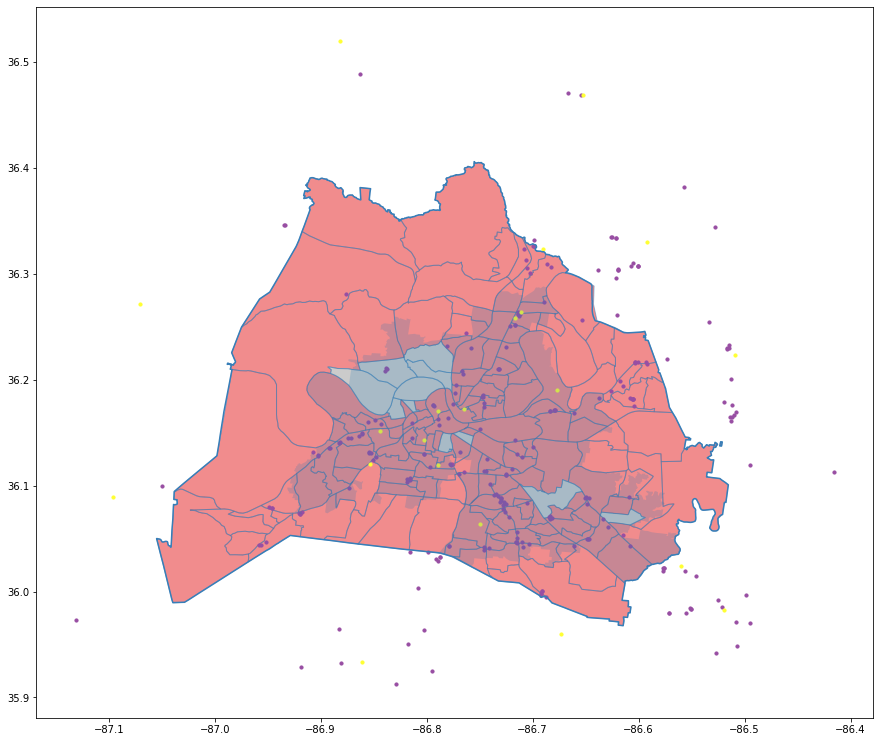

In [110]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = davidson_tracts.plot(ax=ax, column = 'possible_food_desert', categorical = True, cmap = 'Set1', edgecolor = '#377eb8', alpha = 0.5)
ax = davidson_county.boundary.plot(ax=ax, color='#377eb8')
ax = non_dollar_supermarkets.plot(ax=ax, marker='o', color='#984ea3', markersize=10)
ax = davidson_farm_mark.plot(ax=ax, marker='o', color='#ffff33', markersize=10)
ax = davidson_service_districts[davidson_service_districts['name']=='Urban Services District'].plot(ax=ax, alpha = 0.2);

# According to our analysis, the census tracts in gray are food deserts